In [10]:
'''
Date: 13/Jan/2022
Auther: Yike Xie
Content: making figures for cell-cell communication 
'''

'\nDate: 10/01/2021\nAuther: Yike Xie\nContent: making figures for cell-cell communication \n'

In [2]:
import os

import numpy as np
import pandas as pd

import anndata
import scanpy as sc

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from matplotlib import gridspec
import matplotlib as mpl
import seaborn as sns

from collections import defaultdict
import random
import itertools
from numpy import *    

In [11]:
import sys
sys.path.append('/home/yike/phd/dengue/dengue_children/paper_figures/final/modules') 
import YK_util, optimized_pair_comparison, functions_CCC_figure_fra_pair
from YK_util import *
from optimized_pair_comparison import *
from functions_CCC_figure_fra_pair import *

In [7]:
path = '/home/yike/phd/dengue/data/mergedata_20211001YK.h5ad'
adata = sc.read_h5ad(path)
adata_kid = subsetdata(adata)
adata_kid = normalizedata(adata_kid, log1p=True) # log1p = 2
adata_kid = removegenes(adata_kid)

/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [428]:
print('Load interaction') 

fn_int = '/home/yike/phd/dengue/data/interaction_source_file/omni_DB_inters.tsv'
interactions = pd.read_csv(fn_int, sep='\t')[['genesymbol_intercell_source', 'genesymbol_intercell_target']]

genes = np.unique(interactions)
genes = [gene for gene in genes if gene in adata_kid.var_names]

save_tabels = '/home/yike/phd/dengue/data/tables/dataset_20211001/'
save_figures = '/home/yike/phd/dengue/figures/paper_figure/dataset_20211001/final/'

ct_colors = {'megakaryocytes': (0.6313725490196078, 0.788235294117647, 0.9568627450980393),
             'NK_cells': (1.0, 0.7058823529411765, 0.5098039215686274),
             'T_cells': (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
             'plasmacytoid DCs': (1.0, 0.6235294117647059, 0.6078431372549019),
             'Plasmablasts': (0.8156862745098039, 0.7333333333333333, 1.0),
             'Monocytes': (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
             'conventional DCs': (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
             'B_cells': (0.8117647058823529, 0.8117647058823529, 0.8117647058823529)}

Load interaction


# pairwise comparison of cell types and cell subtypes, as well as average expression, fraction of expression

In [14]:
ct_pair = pd.read_csv(save_tabels + 'ct_data_pair_gene_cut_0.tsv', sep='\t', index_col=['cell_subtype', 'gene'])
ct_log2FC = pd.read_csv(save_tabels + 'ct_log2FC_gene_cut_0.tsv', sep='\t', index_col=0)

cst_pair = pd.read_csv(save_tabels + 'cst_data_pair_gene_cut_0.tsv', sep='\t', index_col=['cell_subtype', 'gene'])
cst_log2FC = pd.read_csv(save_tabels + 'cst_log2FC_gene_cut_0.tsv', sep='\t', index_col=0)

# get differential expressed genes involved in interactions

# get the number of interactions at SD and D, threshold: exp frac >= 2%

In [9]:
print('get the number of interactions at SD and D, threshold: exp frac >= 2%')

cts = adata_kid.obs['cell_type_new'].unique().tolist()
cts.remove('doublets')
cts.remove('unknown')

inters = defaultdict(list)

for _, row in interactions.iterrows():
    ga = row['genesymbol_intercell_source']
    gb = row['genesymbol_intercell_target']
    if (ga not in adata_kid.var_names) | (gb not in adata_kid.var_names):
        continue
    for cd, col in zip(['S_dengue', 'dengue'], ['S_fra', 'NS_fra']):
        for cst1 in cts:
            for cst2 in cts:
                exp = {(gene, cst, cd): ct_pair.loc[cst, gene][col] for gene in [ga, gb] for cst in [cst1, cst2]}

                if (exp[ga, cst1, cd] >= 0.02) & (exp[gb, cst2, cd] >= 0.02):
                    inters[(cst1, cst2, cd)].append([ga, gb])
                if (exp[ga, cst2, cd] >= 0.02) & (exp[gb, cst1, cd] >= 0.02):
                    inters[(cst1, cst2, cd)].append([gb, ga])
                
for key in inters.keys():
    if key[0] == key[1]:
        inters[key] = inters[key][::2]
        
its = pd.DataFrame([])
for key in inters.keys():
    inter = pd.DataFrame(inters[key], columns=['ga', 'gb'])
    inter['cell_subtype1'] = [key[0]] * len(inters[key])
    inter['cell_subtype2'] = [key[1]] * len(inters[key])
    inter['condition'] = [key[2]] * len(inters[key])
    
    its = pd.concat([its, inter])

its.to_csv(save_tabels + 'omni_inters_cd_002.tsv', sep='\t', index=False)

get the number of interactions at SD and D, threshold: exp frac >= 2%


<ipython-input-94-d0eda54e5742>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(it_im_new, dtype=np.bool)


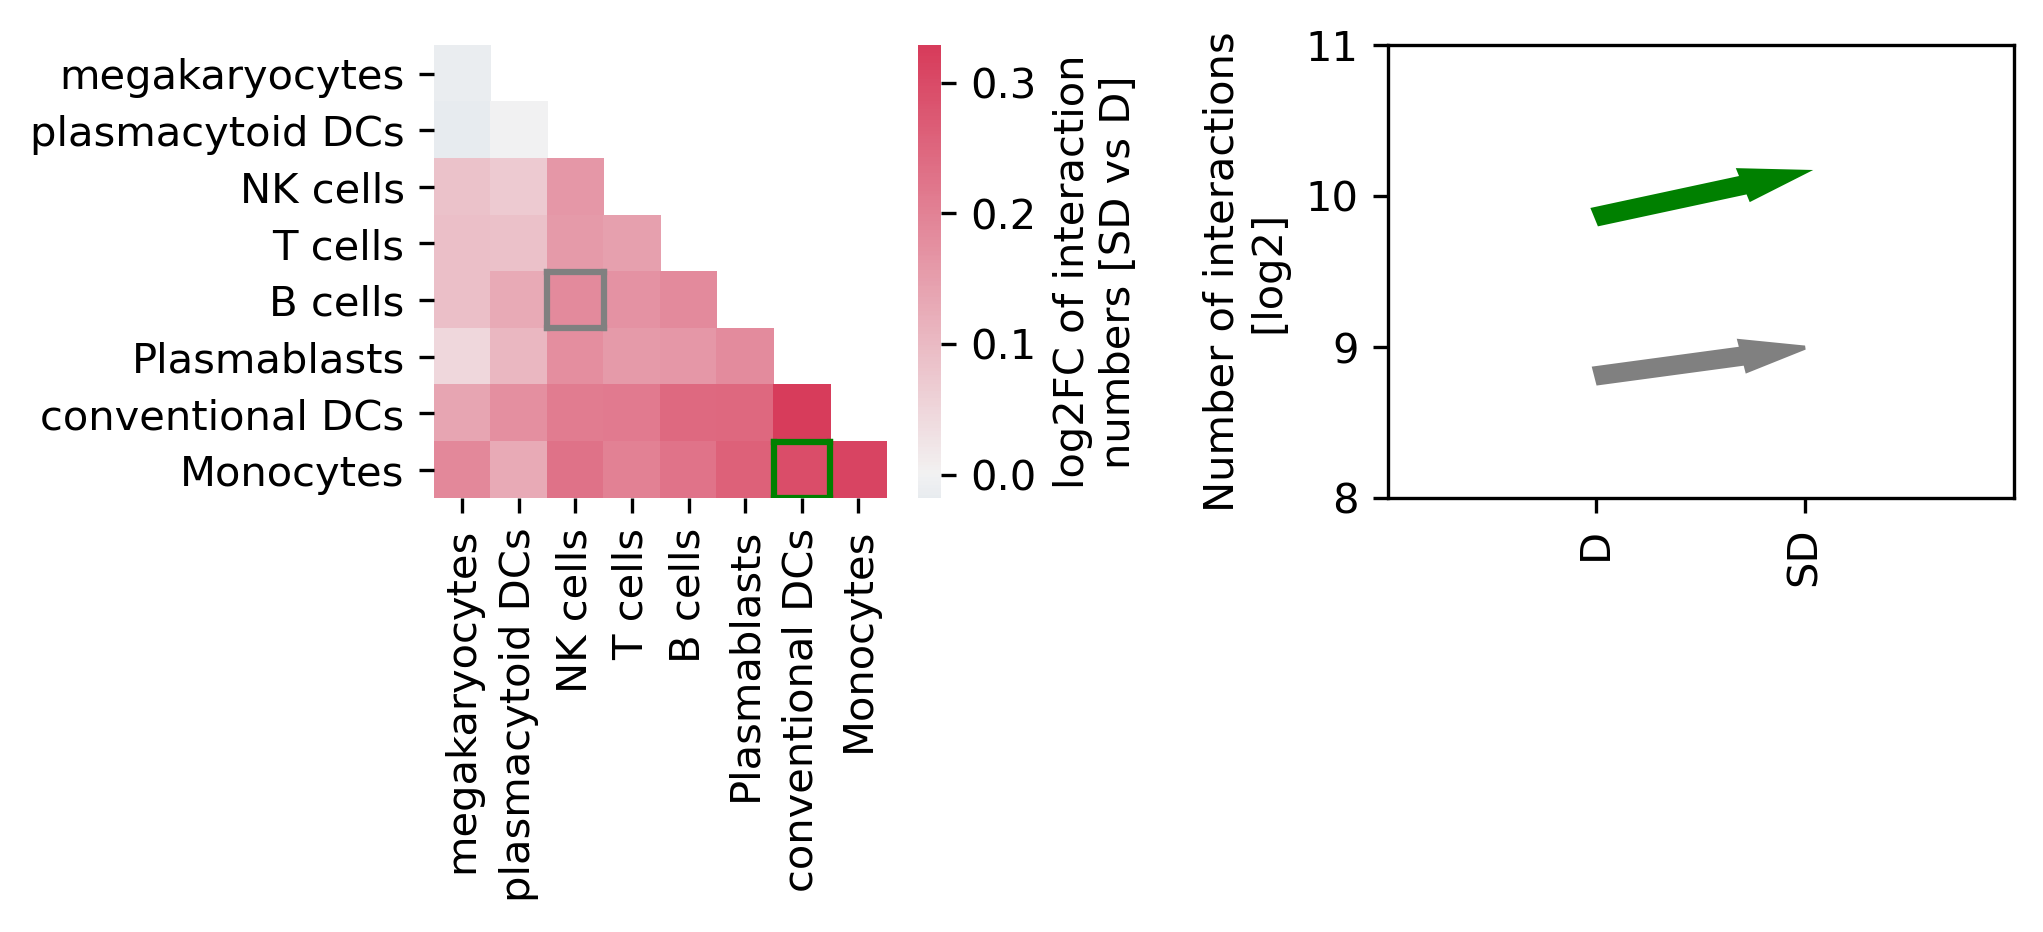

In [94]:
inters_im = pd.read_csv(save_tabels + 'omni_inters_cd_002.tsv', sep='\t', index_col=['cell_subtype1', 'cell_subtype2', 'condition'])
intern_im = {}
for key in inters_im.index:
    intern_im[key] = inters_im.loc[key].shape[0]
    
######################################################################
print('get the heatmap showing the number of interactions at SD and D')
it_im = pd.DataFrame([])
ls_im = defaultdict(list)

cts = adata_kid.obs['cell_type_new'].unique().tolist()
cts.remove('doublets')
cts.remove('unknown')

cell_types = cts

for a in range(len(cell_types)):
    for b in range(len(cell_types)):
        log2fc = np.log2(intern_im[(cell_types[a], cell_types[b], 'S_dengue')]) - np.log2(intern_im[(cell_types[a], cell_types[b], 'dengue')]) 
        ls_im[cell_types[a]].append(log2fc)
    it_im[cell_types[a]] = ls_im[cell_types[a]]
    
it_im.index = pd.Index(cell_types) 

######################################################################
from scipy.spatial.distance import pdist 
distance = pdist(it_im.values) 

from scipy.cluster.hierarchy import linkage, leaves_list
lkg = linkage(distance, optimal_ordering=True)
best_order_im = leaves_list(lkg) 
cts_im_op = it_im.index[best_order_im].tolist()

it_im_new = it_im.loc[cts_im_op][cts_im_op]

######################################################################
fig, axs = plt.subplots(1, 2, figsize=[7, 2], dpi=300) 
plt.subplots_adjust(wspace=0.6)
cmap = sns.diverging_palette(245, 5, as_cmap=True)

mask = np.zeros_like(it_im_new, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
mask[np.diag_indices_from(mask)] = False
sns.heatmap(it_im_new, cmap=cmap, center=0, yticklabels=True, square=True,
                 cbar_kws={'label': 'log2FC of interaction\nnumbers [SD vs D]'}, mask=mask, ax=axs[0])

xlabels = [label.get_text().replace('_', ' ') for label in axs[0].get_xticklabels()]
axs[0].set_xticklabels(xlabels)
ylabels = [label.get_text().replace('_', ' ') for label in axs[0].get_yticklabels()]
axs[0].set_yticklabels(ylabels)

######################################################################
a1 = cts_im_op.index('conventional DCs')
b1 = cts_im_op.index('Monocytes')

a2 = cts_im_op.index('NK_cells')
b2 = cts_im_op.index('B_cells')

for a, b, color in zip((a1, a2), (b1, b2), ('green', 'gray')):
    axs[0].plot([a, a+1], [b, b], color=color)
    axs[0].plot([a+1, a+1], [b, b+1], color=color)
    axs[0].plot([a, a+1], [b+1, b+1], color=color)
    axs[0].plot([a, a], [b, b+1], color=color)

#####################################################################
y_green = [np.log2(intern_im['conventional DCs', 'Monocytes', 'dengue']), 
          np.log2(intern_im['conventional DCs', 'Monocytes', 'S_dengue'])]

y_gray = [np.log2(intern_im['NK_cells', 'B_cells', 'dengue']), 
          np.log2(intern_im['NK_cells', 'B_cells', 'S_dengue'])]

axs[1].arrow(1, y_green[0], 1, y_green[1] - y_green[0], length_includes_head=True, color='green', width=0.1, head_width=0.2)
axs[1].arrow(1, y_gray[0], 1, y_gray[1] - y_gray[0], length_includes_head=True, color='gray', width=0.1, head_width=0.2) 

axs[1].set_xlim(0, 3)
axs[1].set_xticks([1, 2])
axs[1].set_xticklabels(['D', 'SD'], rotation=90)
axs[1].set_ylim(8, 11)
axs[1].set_ylabel('Number of interactions\n[log2]')

plt.show()
fig.savefig(save_figures + 'omni_im_cd_002.png', bbox_inches='tight')

# randomization test to filter significant interactions

In [98]:
cts = adata_kid.obs['cell_type_new'].unique().tolist()
cts.remove('doublets')
cts.remove('unknown')

csts = adata_kid.obs['cell_subtype_new'].unique().tolist()
csts.remove('doublets')
csts.remove('unknown')

res_inters = get_inters_med_pair(ct_pair, cts, 0, 0.02)
res_inters.to_csv(save_tabels + 'inters_med_pair0_exp002.tsv', sep='\t', index=False)

cst_res_inters = get_inters_med_pair(cst_pair, csts, 0, 0.02)
cst_res_inters.to_csv(save_tabels + 'cst_inters_med_pair0_exp002.tsv', sep='\t', index=False)

In [95]:
res_inters = pd.read_csv(save_tabels + 'inters_med_pair0_exp002.tsv', sep='\t')
cst_res_inters = pd.read_csv(save_tabels + 'cst_inters_med_pair0_exp002.tsv', sep='\t')

In [15]:
up = res_inters[res_inters['inter_type'] == 'up']
down = res_inters[res_inters['inter_type'] == 'down']
mix = res_inters[res_inters['inter_type'] == 'mix']

res_up = up[(up['ga_fra_pair'] >= 0.7) & (up['gb_fra_pair'] >= 0.7)]
res_down = down[(down['ga_neg_fra_pair'] >= 0.7) & (down['gb_neg_fra_pair'] >= 0.7)]
res_mix = mix[(mix['ga_fra_pair'] >= 0.7) & (mix['gb_neg_fra_pair'] >= 0.7)]

up_inters = res_up[(res_up['ga_med_pair'] > 0.5) & (res_up['gb_med_pair'] > 0.5)] #83
down_inters = res_down[(res_down['ga_med_pair'] < - 0.5) & (res_down['gb_med_pair'] < - 0.5)] #2
mix_inters = res_mix[(res_mix['ga_med_pair'] > 0.5) & (res_mix['gb_med_pair'] < - 0.5)] #41

for inters, name in zip([up_inters, down_inters, mix_inters], ['up', 'down', 'mix']):
    inters.to_csv(save_tabels + 'filtered_' + name + '_inters.tsv', sep='\t', index=False)
    
inters = pd.concat([up_inters, down_inters, mix_inters])
inters.to_csv(save_tabels + 'filtered' + '_inters.tsv', sep='\t', index=False)

In [16]:
cst_up = cst_res_inters[cst_res_inters['inter_type'] == 'up']
cst_down = cst_res_inters[cst_res_inters['inter_type'] == 'down']
cst_mix = cst_res_inters[cst_res_inters['inter_type'] == 'mix']

cst_res_up = cst_up[(cst_up['ga_fra_pair'] >= 0.7) & (cst_up['gb_fra_pair'] >= 0.7)]
cst_res_down = cst_down[(cst_down['ga_neg_fra_pair'] >= 0.7) & (cst_down['gb_neg_fra_pair'] >= 0.7)]
cst_res_mix = cst_mix[(cst_mix['ga_fra_pair'] >= 0.7) & (cst_mix['gb_neg_fra_pair'] >= 0.7)]

cst_up_inters = cst_res_up[(cst_res_up['ga_med_pair'] > 0.5) & (cst_res_up['gb_med_pair'] > 0.5)] #83
cst_down_inters = cst_res_down[(cst_res_down['ga_med_pair'] < - 0.5) & (cst_res_down['gb_med_pair'] < - 0.5)] #2
cst_mix_inters = cst_res_mix[(cst_res_mix['ga_med_pair'] > 0.5) & (cst_res_mix['gb_med_pair'] < - 0.5)] #41

for cst_inters, name in zip([cst_up_inters, cst_down_inters, cst_mix_inters], ['up', 'down', 'mix']):
    cst_inters.to_csv(save_tabels + 'filtered_' + name + '_cst_inters.tsv', sep='\t', index=False)
    
cst_inters = pd.concat([cst_up_inters, cst_down_inters, cst_mix_inters])
cst_inters.to_csv(save_tabels + 'filtered' + '_cst_inters.tsv', sep='\t', index=False)

In [18]:
r_genes = [{'ga': ga, 'cta': cta, 'gb': gb, 'ctb': ctb} for ga, cta, gb, ctb in zip(inters['ga'].tolist(), 
                                                                                    inters['csta'].tolist(), 
                                                                                    inters['gb'].tolist(), 
                                                                                    inters['cstb'].tolist())]
ran_res = randomization(r_genes, adata_kid)
ran_res.to_csv(save_tabels + 'randomization_inters.tsv', sep='\t')

/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


0


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attrib

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attrib

100


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attrib

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attrib

200


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attrib

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [19]:
cst_r_genes = [{'ga': ga, 'cta': cta, 'gb': gb, 'ctb': ctb} for ga, cta, gb, ctb in zip(cst_inters['ga'].tolist(), 
                                                                                    cst_inters['csta'].tolist(), 
                                                                                    cst_inters['gb'].tolist(), 
                                                                                    cst_inters['cstb'].tolist())]
ran_cst_res = randomization(cst_r_genes, adata_kid)
ran_cst_res.to_csv(save_tabels + 'randomization_cst_inters.tsv', sep='\t')

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


0


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attrib

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attrib

100


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attrib

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attrib

200


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attrib

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attrib

300


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attrib

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attrib

400


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attrib

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attrib

500


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attrib

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attrib

600


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attrib

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attrib

700


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attrib

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attrib

800


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attrib

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attrib

900


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attrib

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attrib

1000


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [28]:
ran_ct_filter = ran_filter(ran_res, r_genes)
ran_ct_filter.to_csv(save_tabels + 'filtered_randomization_inters.tsv', sep='\t', index=False)

ran_ct_filter.set_index(['ga', 'csta', 'gb', 'cstb'], inplace=True)
inters.set_index(['ga', 'csta', 'gb', 'cstb'], inplace=True)
res = inters.loc[ran_ct_filter.index]
res = res[~res.duplicated()]
res.to_csv(save_tabels + 'filtered_sig_inters.tsv', sep='\t')

<ipython-input-25-a565af1a3728>:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  if ran_res.loc[ga, csta, gb, cstb][:1]['pvalue'][0] == 0:
<ipython-input-25-a565af1a3728>:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  loc = ran_res.loc[ga, csta, gb, cstb][:1].loc[ga, csta, gb, cstb].tolist()


In [30]:
ran_cst_filter = ran_filter(ran_cst_res, cst_r_genes)
ran_cst_filter.to_csv(save_tabels + 'filtered_randomization_cst_inters.tsv', sep='\t', index=False)

ran_cst_filter.set_index(['ga', 'csta', 'gb', 'cstb'], inplace=True)
cstT_inters.set_index(['ga', 'csta', 'gb', 'cstb'], inplace=True)
cst_res = cst_inters.loc[ran_cst_filter.index]
cst_res = cst_res[~cst_res.duplicated()]
cst_res.to_csv(save_tabels + 'filtered_sig_cst_inters.tsv', sep='\t')

<ipython-input-25-a565af1a3728>:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  if ran_res.loc[ga, csta, gb, cstb][:1]['pvalue'][0] == 0:
<ipython-input-25-a565af1a3728>:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  loc = ran_res.loc[ga, csta, gb, cstb][:1].loc[ga, csta, gb, cstb].tolist()


### randomization plot

<ipython-input-110-3cfae11d25bd>:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  randomization_plot(save_figures, res.loc['LGALS3', 'NK_cells', 'LAG3', 'NK_cells'], ran_res[~ran_res.duplicated()])
<ipython-input-102-cd950f8eb0a1>:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  log2fc = ran_res.loc[ga, cta, gb, ctb]
<ipython-input-102-cd950f8eb0a1>:28: PerformanceWarning: indexing past lexsort depth may impact performance.
  p = ran_res.loc[ga, cta, gb, ctb]['pvalue'][0]


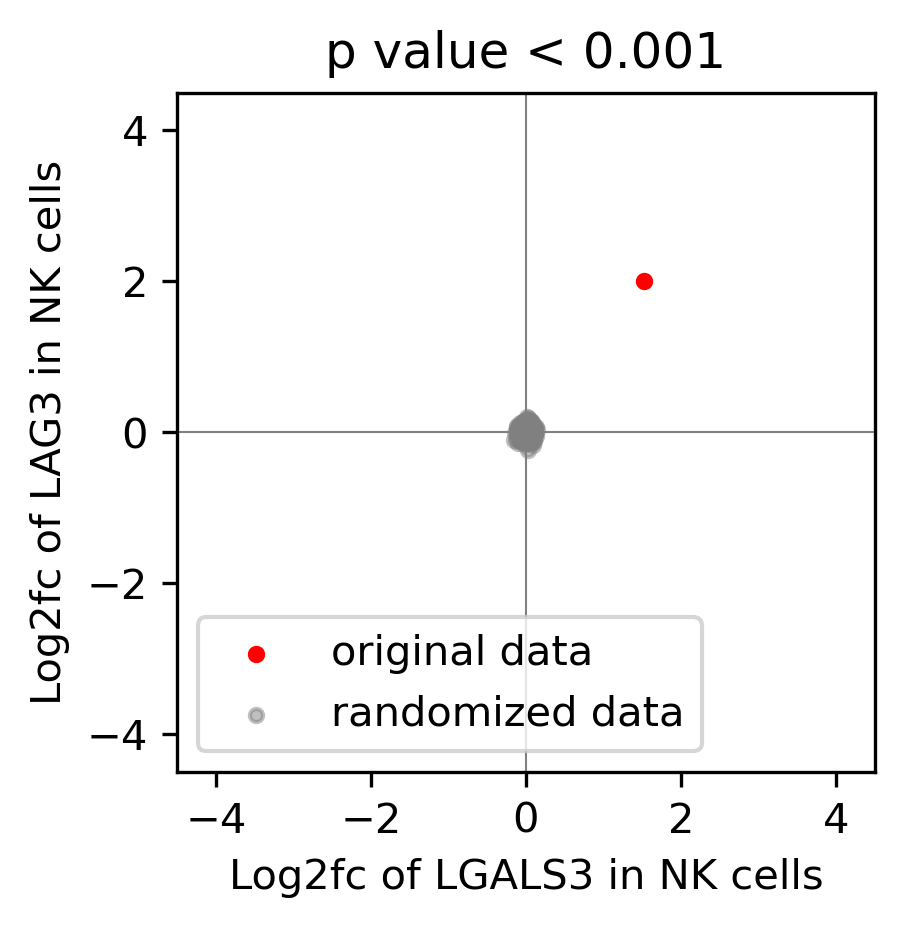

In [110]:
res = pd.read_csv(save_tabels + 'filtered_sig_inters.tsv', sep='\t', index_col=['ga', 'csta', 'gb', 'cstb'])
ran_res = pd.read_csv(save_tabels + 'randomization_inters.tsv', sep='\t', index_col=['ga', 'cta', 'gb', 'ctb'])
randomization_plot(save_figures, res.loc['LGALS3', 'NK_cells', 'LAG3', 'NK_cells'], ran_res[~ran_res.duplicated()])

### violin plot of a significant interaction after randomization test

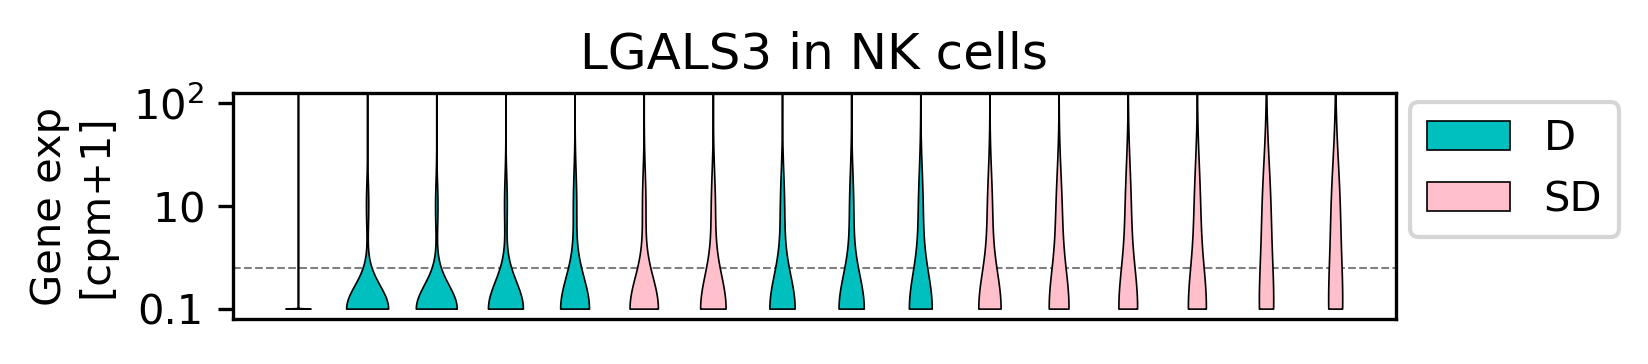

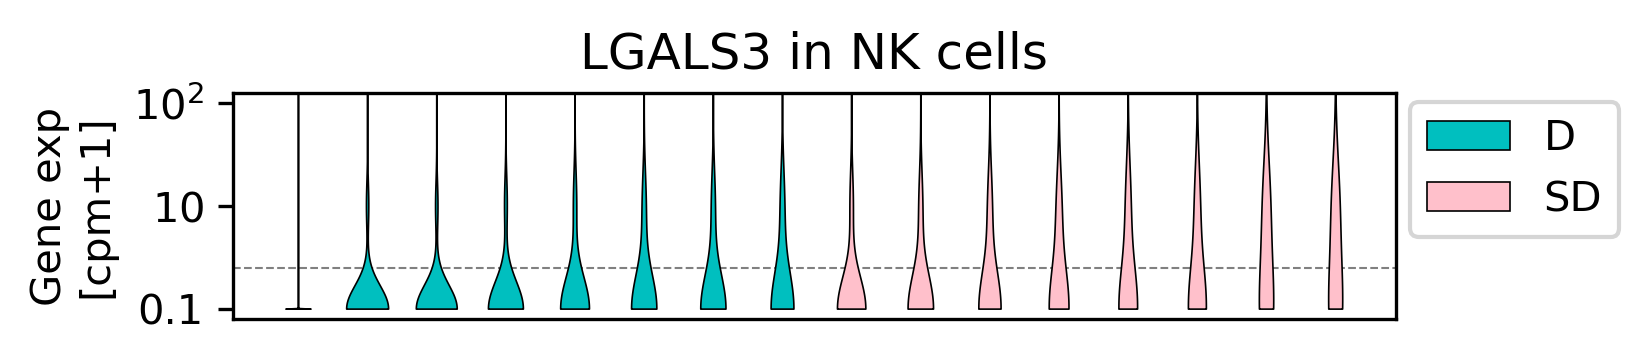

In [307]:
violin('LGALS3', 'NK_cells', fdn=save_figures)

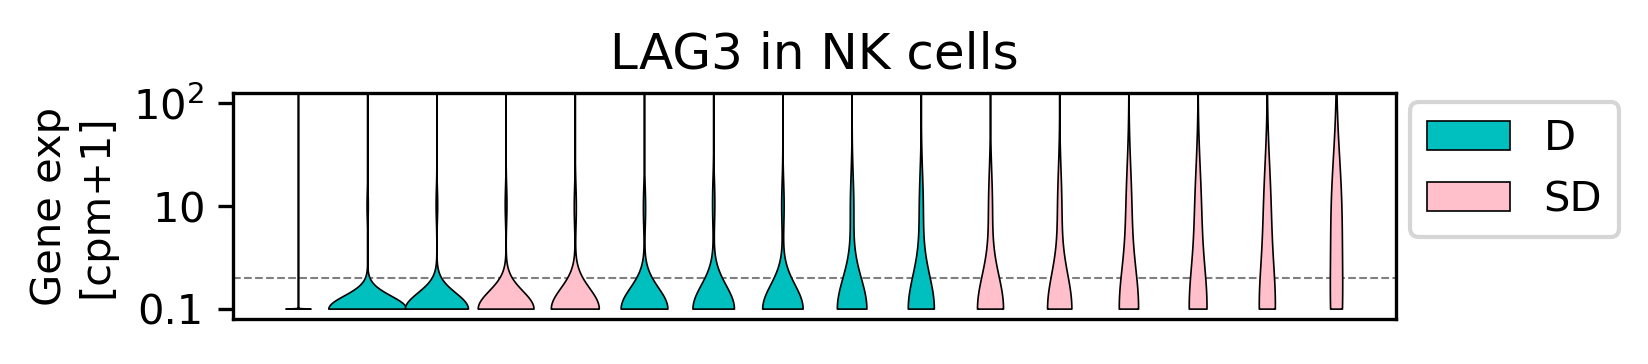

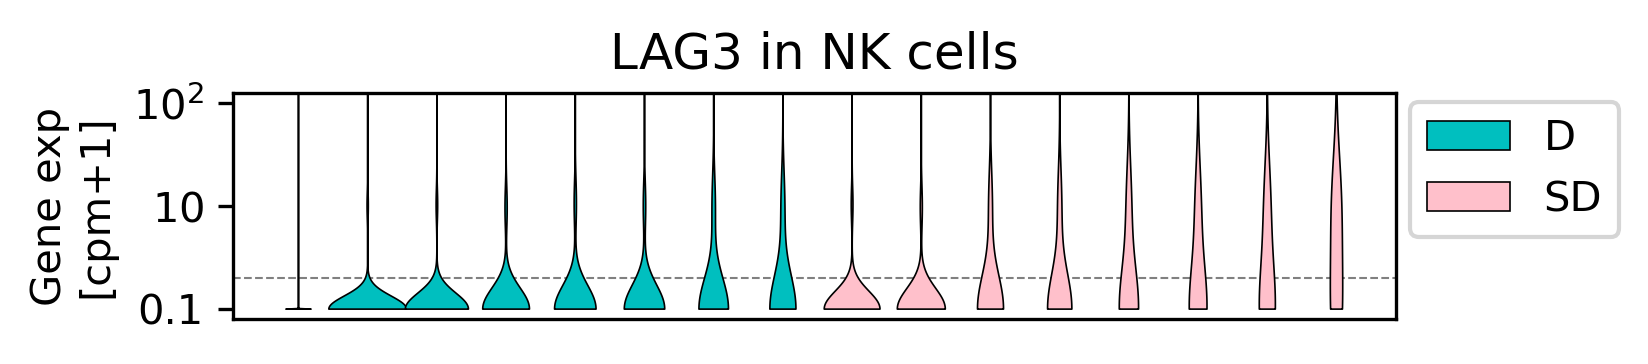

In [308]:
violin('LAG3', 'NK_cells', fdn=save_figures)

# Get the ratio between number of downregulated genes and upregulated genes in each cell type

In [318]:
print('only analyzing interacting genes')
cts = adata_kid.obs['cell_type_new'].unique().tolist()
cts.remove('doublets')
cts.remove('unknown')

genes = np.unique(interactions)
genes = [gene for gene in genes if gene in adata_kid.var_names]

ratio = []
for ct in cts:
    data_ct = ct_pair.loc[ct].loc[genes]
    up_ct = ((data_ct['med_pair'] >= 1) & (data_ct['fra_pair'] >= 0.7) & (data_ct['S_fra'] >= 0.02)).sum()
    down_ct = ((data_ct['med_pair'] <= -1) & (data_ct['neg_fra_pair'] >= 0.7) & (data_ct['NS_fra'] >= 0.02)).sum()
    ratio_ct = (up_ct / (up_ct + down_ct)) * 100
    ratio.append([ct, ratio_ct, str(up_ct) + '/' + str(up_ct + down_ct)])

ratio = pd.DataFrame(ratio, 
                     columns=['cell_type', 'Downregulated vs upregulated DEGs [%]', 'Number']).sort_values('Downregulated vs upregulated DEGs [%]')

only analyzing interacting genes


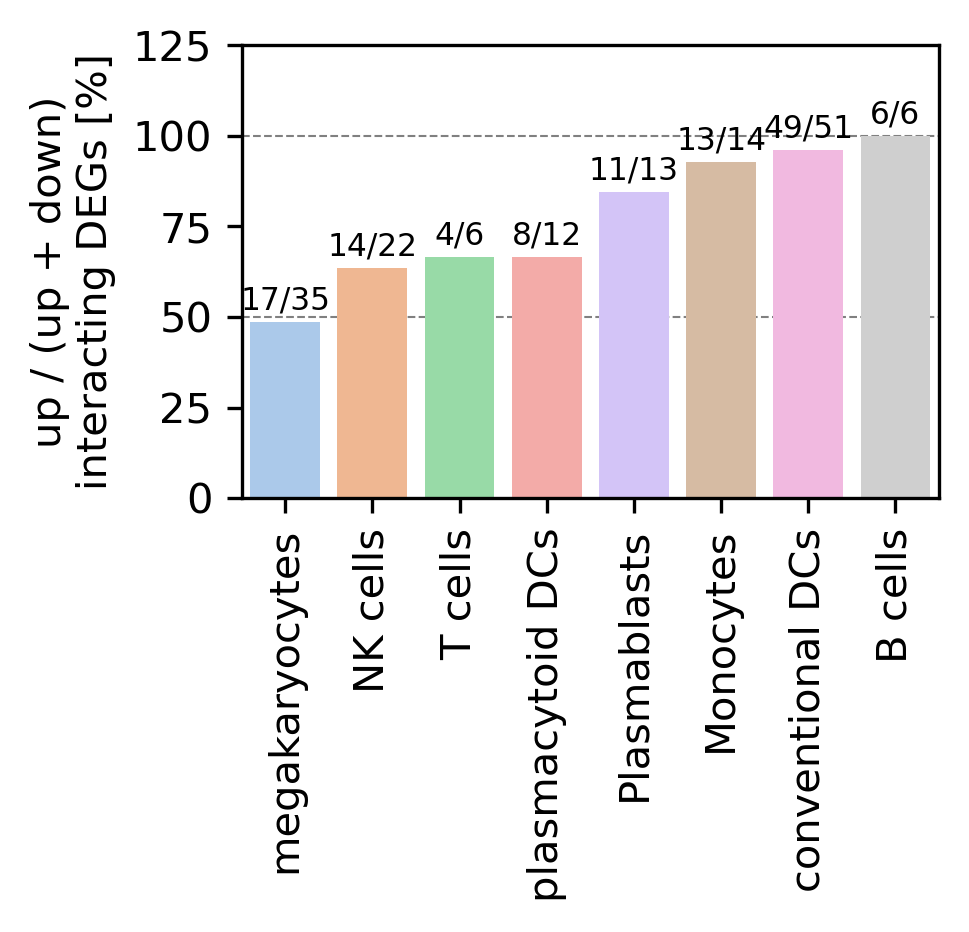

In [399]:
fig, ax = plt.subplots(figsize=[3, 2], dpi=300)
sns.barplot(data=ratio, x='cell_type', y='Downregulated vs upregulated DEGs [%]', palette='pastel', ax=ax) # orient='h',

for p, name_n in zip(ax.patches, ratio['Number']):
    ax.annotate(name_n, 
                (p.get_x() + 0.4, p.get_height() + 15), 
                ha = 'center', va = 'center', 
                size=7.5,
                xytext = (0, -8), 
                textcoords = 'offset points',
                #rotation=90
               )
for h in (50, 100):    
    ax.axhline(h, c='gray', lw=0.5, ls='--', zorder=0.5)
ax.set_xlabel(None)
ax.set_ylabel(None)
labels = [label.get_text() for label in ax.get_xticklabels()]
labels = [label.replace('_', ' ') for label in labels]
ax.set_xticklabels(labels, rotation=90)
ax.set_ylim([0, ax.get_ylim()[1] + 20])
ax.set_ylabel('up / (up + down)\ninteracting DEGs [%]')
fig.savefig(save_figures + 'Down_DEGs_vs_DEGs.png',bbox_inches='tight')

# ct_colors  = {ct: c for ct, c in zip(labels, sns.color_palette('pastel')[:8])}

# get final significant interactions: med_pair >=1 or <= -1, fra_pair >= 0.7

In [493]:
res = pd.read_csv(save_tabels + 'filtered_sig_inters.tsv', sep='\t')
up_inters = res[res['inter_type'] == 'up'] # 142
down_inters = res[res['inter_type'] == 'down'] # 14
mix_inters = res[res['inter_type'] == 'mix'] # 59

print('filter cell_type interactions using med_pair >= 1')
up = up_inters[(up_inters['ga_med_pair'] >= 1) & (up_inters['gb_med_pair'] >= 1)] # 56
down = down_inters[(down_inters['ga_med_pair'] <= -1) & (down_inters['gb_med_pair'] <= -1)] # 0
mix = mix_inters[(mix_inters['ga_med_pair'] >= 1) & (mix_inters['gb_med_pair'] <= -1)] # 18

##########################################################
cst_res = pd.read_csv(save_tabels + 'filtered_sig_cst_inters.tsv', sep='\t')
up_cst_inters = cst_res[cst_res['inter_type'] == 'up'] # 460
down_cst_inters = cst_res[cst_res['inter_type'] == 'down'] # 54
mix_cst_inters = cst_res[cst_res['inter_type'] == 'mix'] # 261

print('filter cell_subtype interactions using med_pair >= 1')
up_cst = up_cst_inters[(up_cst_inters['ga_med_pair'] >= 1) & (up_cst_inters['gb_med_pair'] >= 1)] # 133
down_cst = down_cst_inters[(down_cst_inters['ga_med_pair'] <= -1) & (down_cst_inters['gb_med_pair'] <= -1)] # 12
mix_cst = mix_cst_inters[(mix_cst_inters['ga_med_pair'] >= 1) & (mix_cst_inters['gb_med_pair'] <= -1)] # 53

##########################################################
for data, name in zip([up, down, mix], ['up', 'down', 'mix']):
    data.to_csv(save_tabels + 'final/final_' + name + '_ct_inters.tsv', sep='\t', index=False)

for data, name in zip([up_cst, down_cst, mix_cst], ['up', 'down', 'mix']):
    data.to_csv(save_tabels + 'final/final_' + name + '_cst_inters.tsv', sep='\t', index=False)

##########################################################
cts_filter = pd.concat([up, down, mix]).set_index(['ga', 'csta', 'gb', 'cstb']) # 74
csts_filter = pd.concat([up_cst, down_cst, mix_cst]).set_index(['ga', 'csta', 'gb', 'cstb']) # 198

cts_filter.to_csv(save_tabels + 'final/final_' + 'ct_inters.tsv', sep='\t')
csts_filter.to_csv(save_tabels + 'final/final_' + 'cst_inters.tsv', sep='\t')

filter cell_type interactions using med_pair >= 1
filter cell_subtype interactions using med_pair >= 1


In [494]:
print('load final flitered interactions')
up = pd.read_csv(save_tabels + 'final/final_' + 'up' + '_ct_inters.tsv', sep='\t')
down = pd.read_csv(save_tabels + 'final/final_' + 'down' + '_ct_inters.tsv', sep='\t')
mix = pd.read_csv(save_tabels + 'final/final_' + 'mix' + '_ct_inters.tsv', sep='\t')

up_cst = pd.read_csv(save_tabels + 'final/final_' + 'up' + '_cst_inters.tsv', sep='\t')
down_cst = pd.read_csv(save_tabels + 'final/final_' + 'down' + '_cst_inters.tsv', sep='\t')
mix_cst = pd.read_csv(save_tabels + 'final/final_' + 'mix' + '_cst_inters.tsv', sep='\t')

cts_filter = pd.read_csv(save_tabels + 'final/final_' + 'ct_inters.tsv', sep='\t', index_col=['ga', 'csta', 'gb', 'cstb'])
csts_filter = pd.read_csv(save_tabels + 'final/final_' + 'cst_inters.tsv', sep='\t', index_col=['ga', 'csta', 'gb', 'cstb'])

load final flitered interactions


# get heatmaps showing number of interactions after randomization test

get heatmap showing the number of upregulated interactions


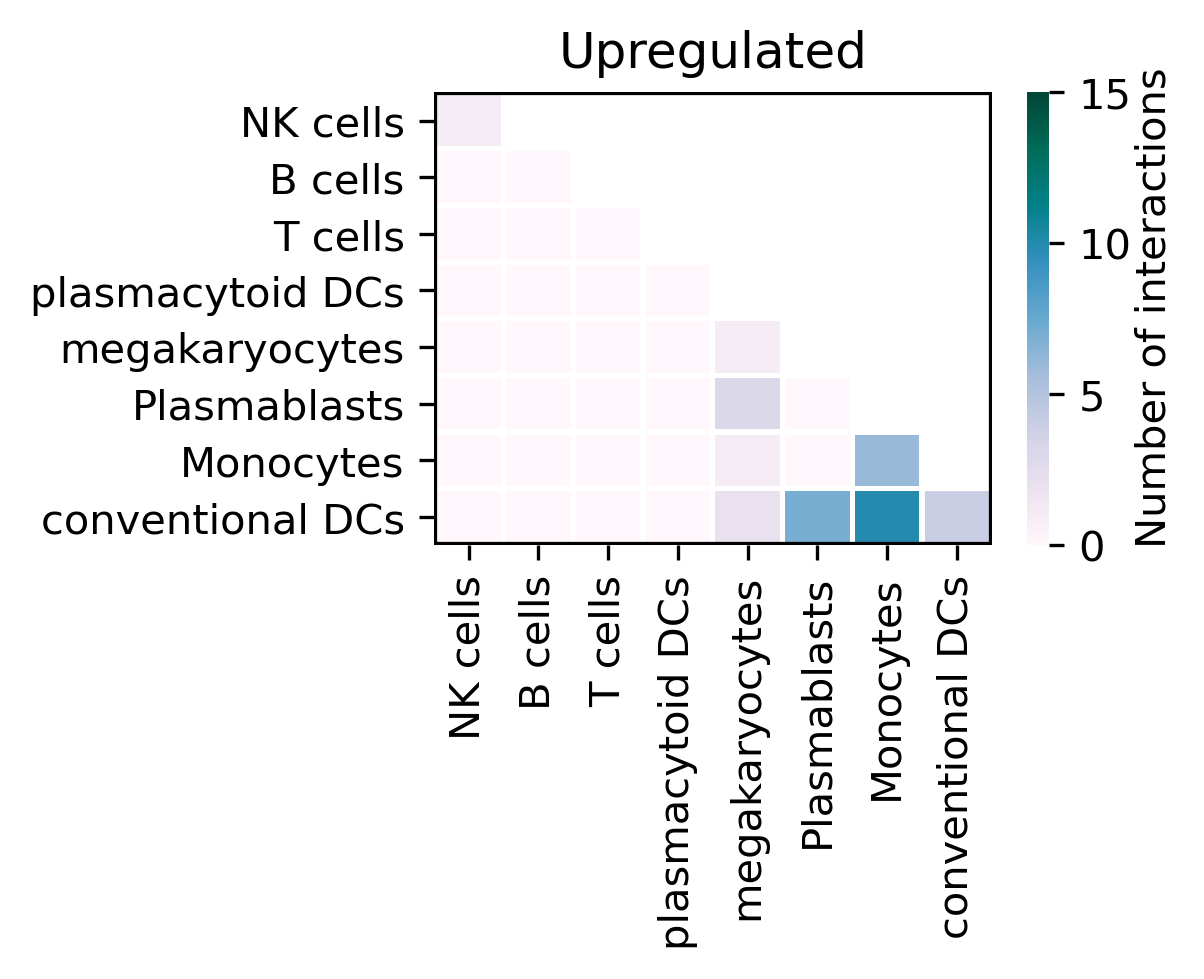

In [499]:
#from make_figure_functions import inter_number
print('get heatmap showing the number of upregulated interactions')
fig = inter_number(adata_kid, up, 15, 'Up', 'PuBuGn')['figure']
fig.savefig(save_figures + 'up_inters_2.png', bbox_inches='tight')

In [34]:
print('get heatmap showing the number of downregulated interactions')
#inter_number(adata_kid, down_inters, 5, 'Down')

get heatmap showing the number of downregulated interactions


get heatmap showing the number of mixregulated interactions


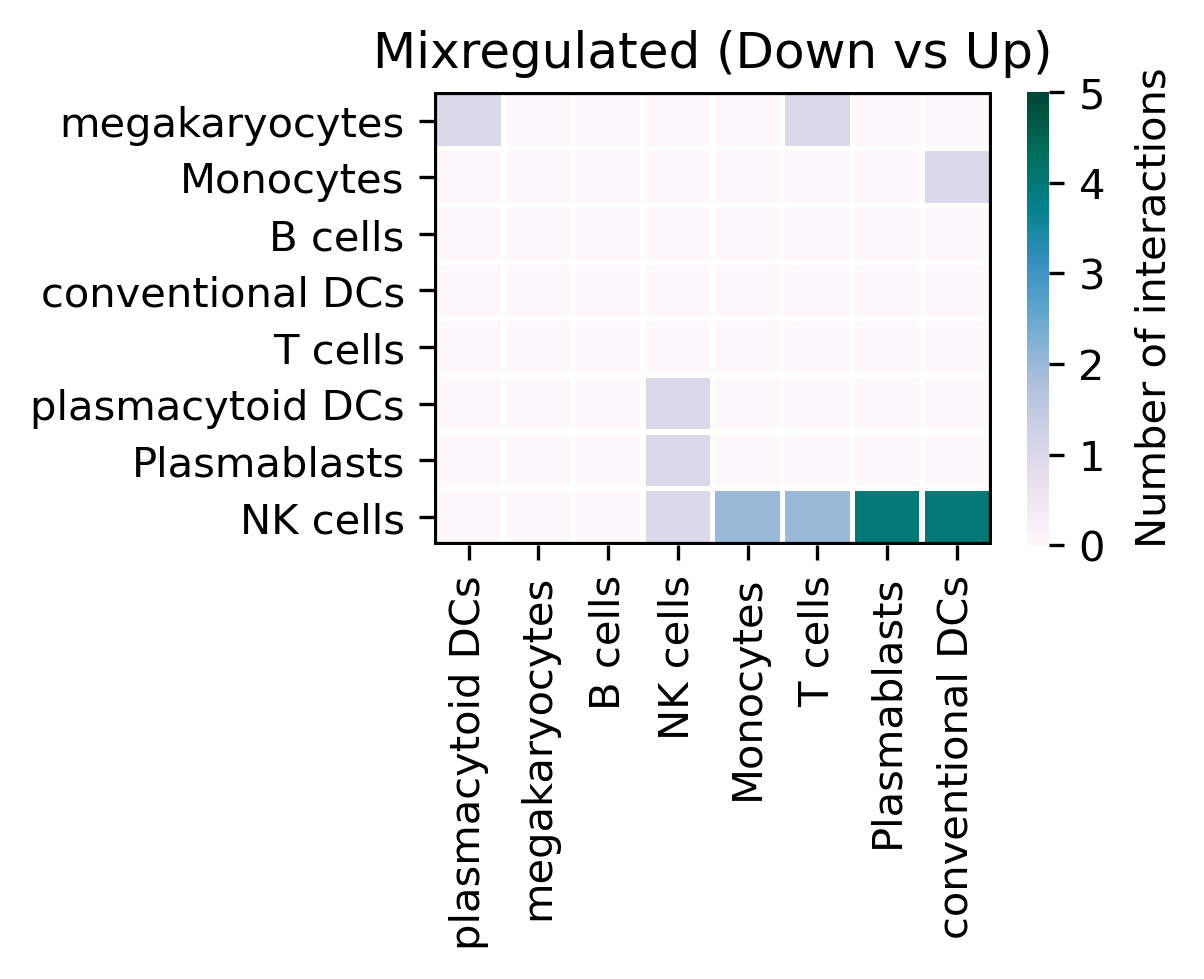

In [391]:
#from make_figure_functions import inter_mix_number
print('get heatmap showing the number of mixregulated interactions')
fig = inter_mix_number(adata_kid, mix, 5, 'PuBuGn')['figure']
fig.savefig(save_figures + 'mix_inters_2.png', bbox_inches='tight')

# Specific interactions in cts or csts

In [510]:
cts_inters = cts_filter.index
csts_inters = csts_filter.index

ct_cst = {
    'Monocytes': ['Classical_monocytes',  'Macrophages', 'non_classical_monocytes'], 
    'Plasmablasts': ['non_cycling Plasmablasts', 'cycling Plasmablasts',],
    'B_cells': ['naive B cells', 'memory B cells', 'activated B cells'],
    'T_cells': ['CD4+ T cells', 'CD8+ effector T cells', 'CD8+ naive/memory T cells',],
    'NK_cells': ['XCL_low NK cells', 'XCL_high NK cells',],
    'megakaryocytes': ['megakaryocytes'],
    'conventional DCs': ['conventional DCs'],
    'plasmacytoid DCs': ['plasmacytoid DCs'],
}

In [511]:
cst_in = []
cst_out = []

for inter in csts_inters:
    for key1 in ct_cst.keys():
        if inter[1] in ct_cst[key1]:
            ct1 = key1
    for key2 in ct_cst.keys():
        if inter[3] in ct_cst[key2]:
            ct2 = key2
    interi = (inter[0], ct1, inter[2], ct2)
    interj = ( inter[2], ct2, inter[0], ct1)
    
    if (interi in cts_inters) | (interj in cts_inters):
        cst_in.append(inter)
    else:
        cst_out.append(inter)

In [512]:
print('get interactions with same genes and coresponding cell subtypes as significant cts inters')
in_inter = cst_res.set_index(['ga', 'csta', 'gb', 'cstb']).loc[cst_in]
in_inter = in_inter[~in_inter.duplicated()]
in_inter.to_csv(save_tabels + 'final/cst_inters_in_cts_strict.tsv', sep='\t')

out_inter = cst_res.set_index(['ga', 'csta', 'gb', 'cstb']).loc[cst_out]
out_inter = out_inter[~out_inter.duplicated()]
out_inter.to_csv(save_tabels + 'final/cst_inters_out_cts_strict.tsv', sep='\t')

get interactions with same genes and coresponding cell subtypes as significant cts inters


# get barplot shwoing gene number in distinct cell types from sig_inters

only use interactions with med_pair >=1 or <= -1


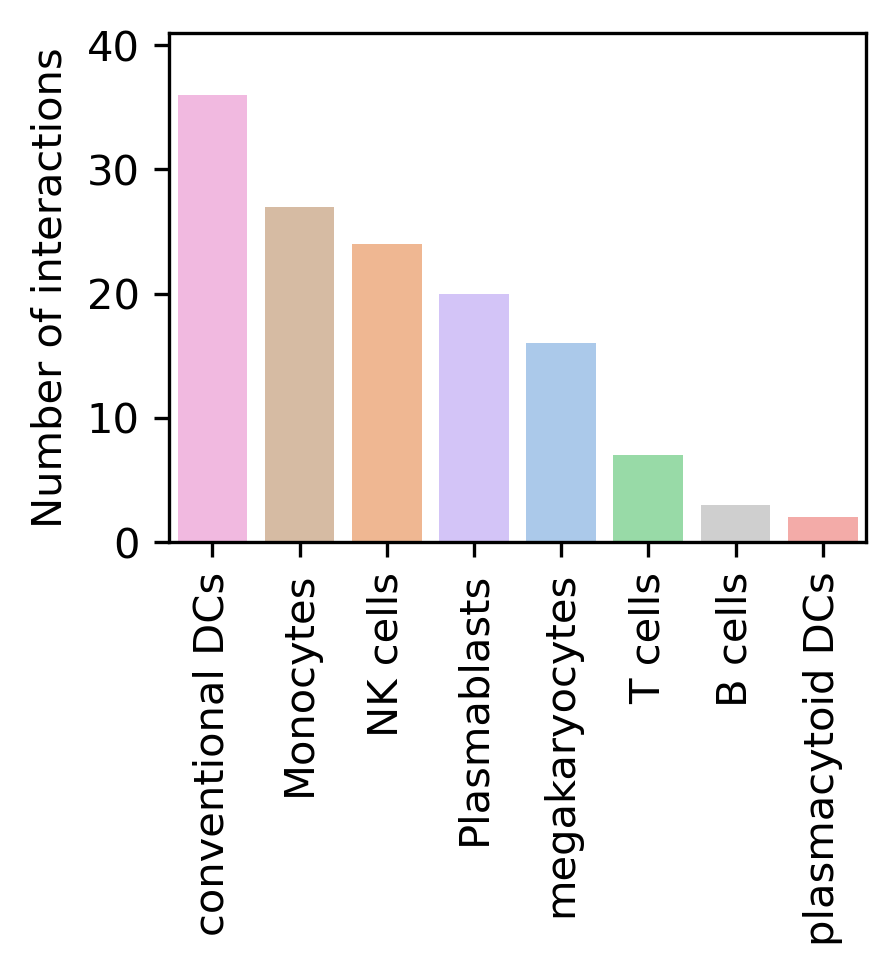

In [431]:
print('only use interactions with med_pair >=1 or <= -1')
cts = adata_kid.obs['cell_type_new'].unique().tolist()
cts.remove('doublets')
cts.remove('unknown')

ct_n = {ct: 0 for ct in cts}
for inter in cts_inters:
    for ct in cts:
        if inter[1] == ct:
            ct_n[ct] += 1
        elif inter[3] == ct:
            ct_n[ct] += 1

#######################################################
sig_it_n = pd.DataFrame(ct_n.values(), columns=['Number of interactions'])
sig_it_n['Cell type'] = ct_n.keys()
sig_it_n.sort_values('Number of interactions', ascending=False, inplace=True)

#######################################################
palette = [ct_colors[ct] for ct in sig_it_n['Cell type']]
fig, ax = plt.subplots(figsize=[3, 2.25], dpi=300)
ax = sns.barplot(data=sig_it_n, x='Cell type', y='Number of interactions', palette=palette)
ax.set_xticklabels([ct.replace('_', ' ') for ct in sig_it_n['Cell type'].tolist()], rotation=90)
ax.set_ylim(0, (sig_it_n['Number of interactions'].iloc[0] // 10 + 1) * 10 + 1)
ax.set_xlabel(None)
ax.set_ylabel('Number of interactions')
fig.savefig(save_figures + 'n_inters_cts.png', bbox_inches='tight')

In [517]:
def cst_number(cst_its, Mon_cst, color):
    cst_its = cst_its[~ cst_its.duplicated()]
    cst_inters = cst_its.index

    Mon_n = {cst: 0 for cst in Mon_cst}
    for inter in cst_inters:
        for cst in Mon_cst:
            if inter[1] == cst:
                Mon_n[cst] += 1
            elif inter[3] == cst:
                Mon_n[cst] += 1

    Mon_it_n = pd.DataFrame(Mon_n.values(), columns=['Number of interactions'])
    Mon_it_n['Cell subtype'] = [cst.replace('_', ' ') for cst in Mon_n.keys()]
    Mon_it_n.sort_values('Number of interactions', ascending=False, inplace=True)
    
    fig, ax = plt.subplots(figsize=[0.9, 1], dpi=300)
    sns.barplot(data=Mon_it_n, x='Cell subtype', y='Number of interactions', ax=ax, color=color)
    ax.set_xticklabels([ct.replace('_', ' ') for ct in Mon_cst], rotation=90)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    
    ylim = (Mon_it_n['Number of interactions'].max() // 10 + 1) * 10 + 1
    ax.set_ylim(0, ylim)
    ax.set_yticks(range(0, ylim, [10, 20][ylim >= 40]))
    ax.set_yticklabels(range(0, ylim, [10, 20][ylim >= 40]))
        
    return {'figure': fig, 'ax': ax}

<ipython-input-517-f7f8bbff0f21>:25: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  ax.set_yticks(range(0, ylim, [10, 20][ylim >= 40]))
<ipython-input-517-f7f8bbff0f21>:26: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  ax.set_yticklabels(range(0, ylim, [10, 20][ylim >= 40]))
<ipython-input-517-f7f8bbff0f21>:25: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  ax.set_yticks(range(0, ylim, [10, 20][ylim >= 40]))
<ipython-input-517-f7f8bbff0f21>:26: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  ax.set_yticklabels(range(0, ylim, [10, 20][ylim >= 40]))
<ipython-input-517-f7f8bbff0f21>:25: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  ax.set_yticks(range(0, ylim, [10, 20][ylim >= 40]))
<ipython-input-

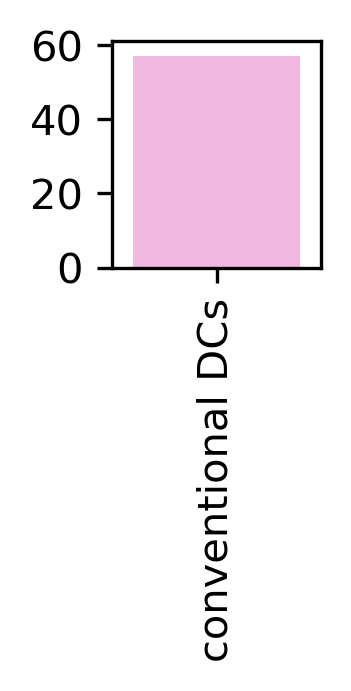

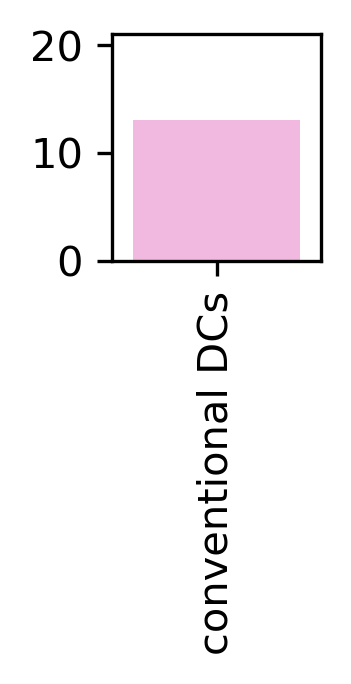

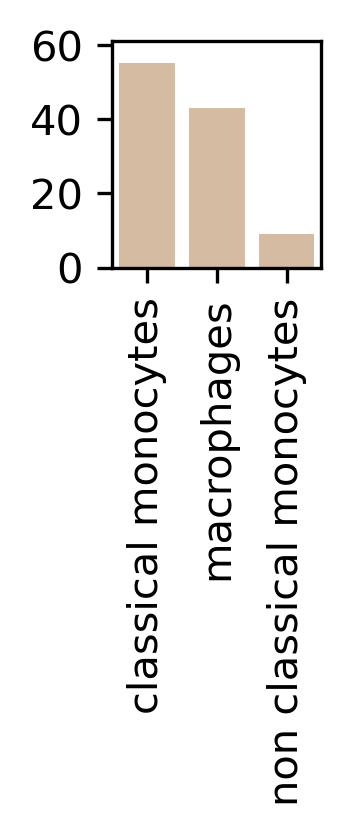

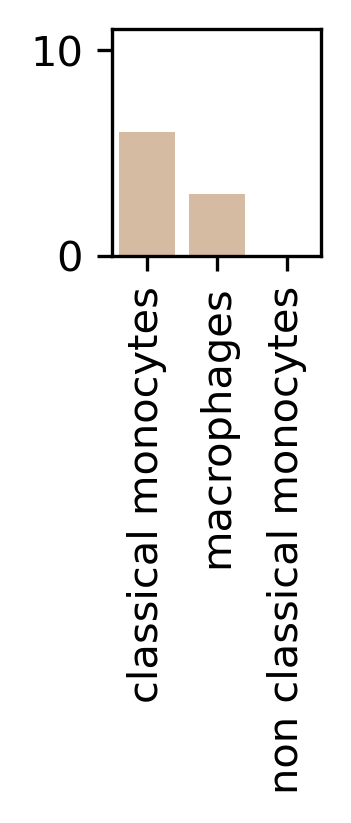

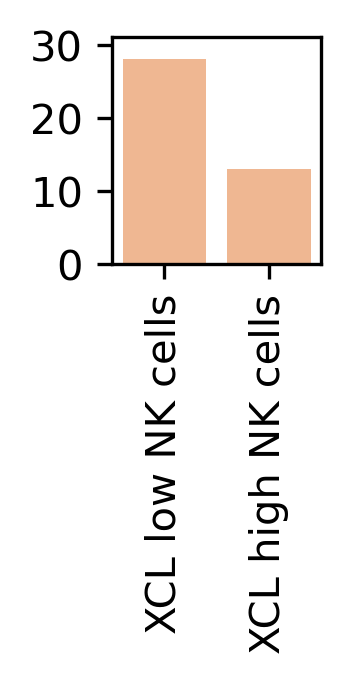

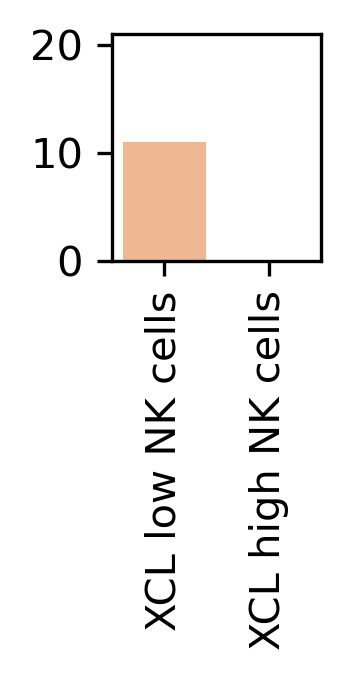

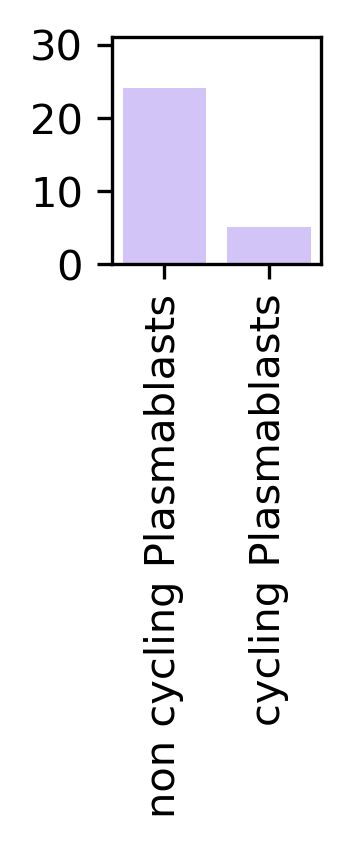

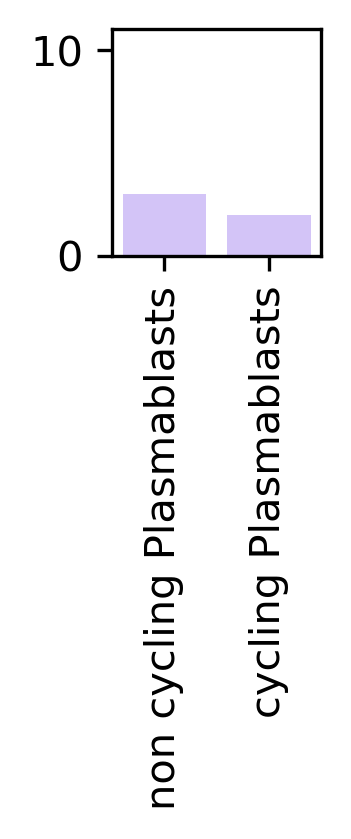

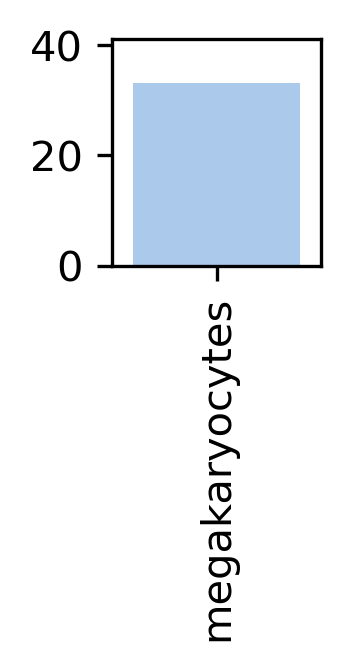

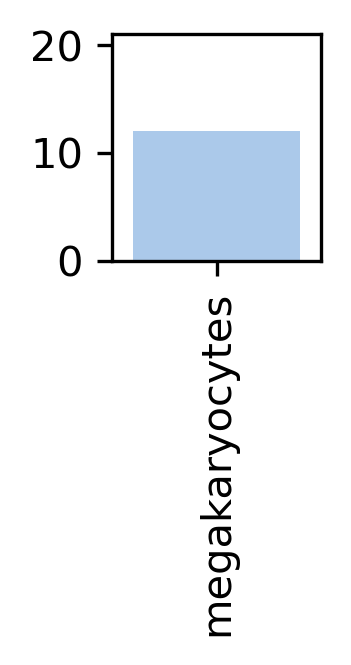

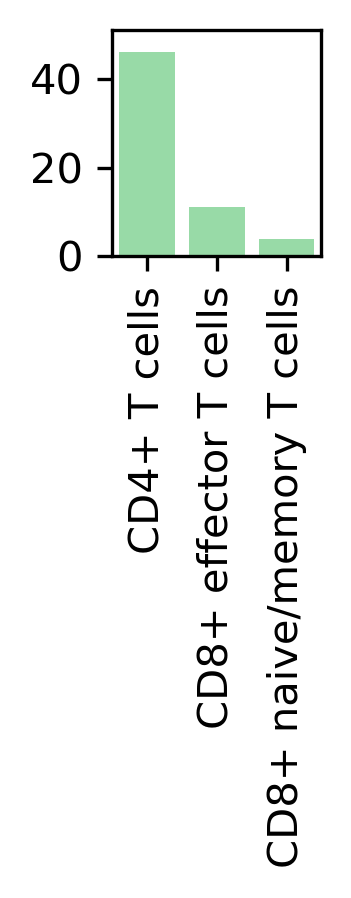

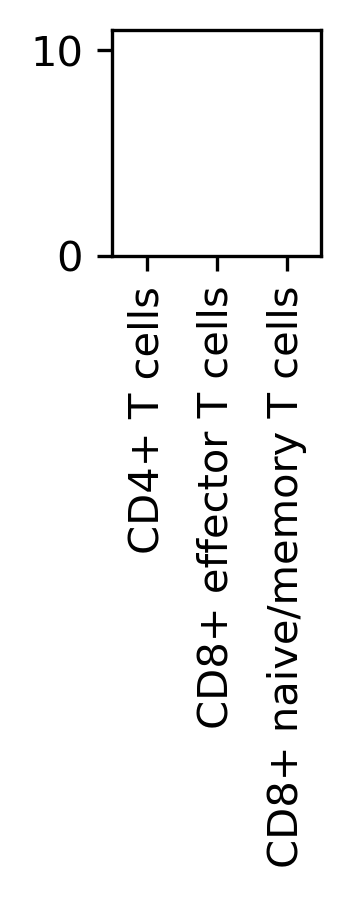

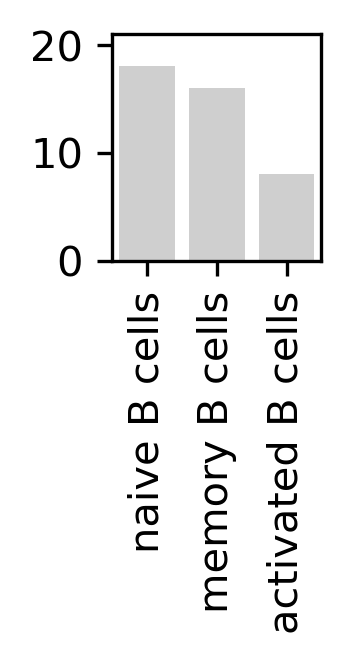

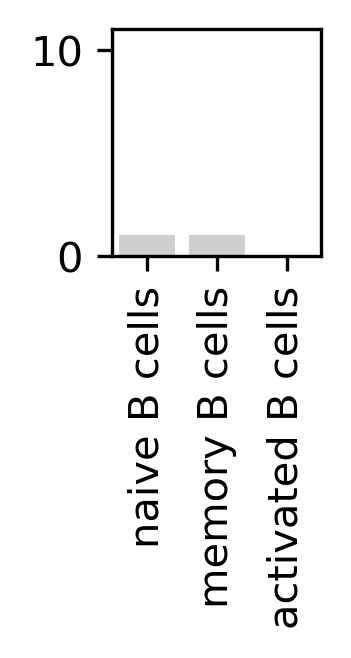

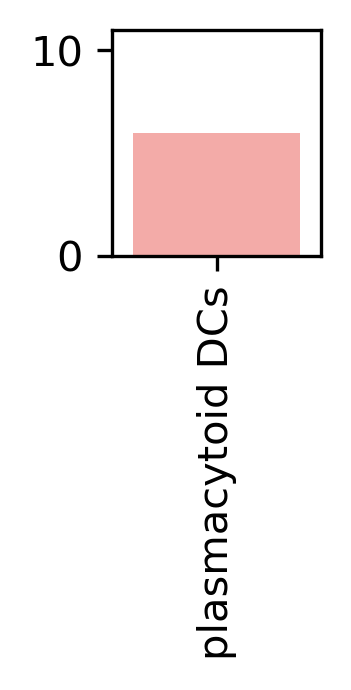

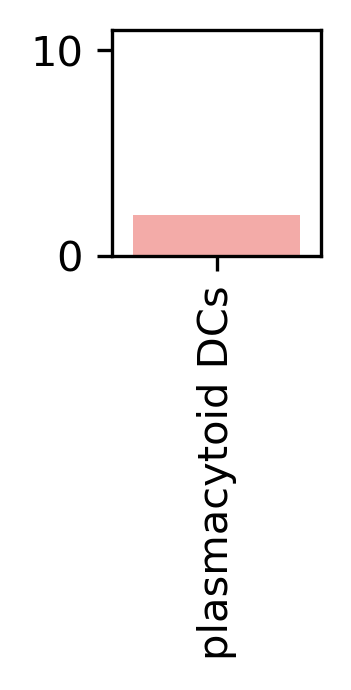

In [518]:
ct_cst = {
    'Monocytes': ['classical monocytes',  'macrophages', 'non_classical monocytes'],
    'Plasmablasts': ['non_cycling Plasmablasts', 'cycling Plasmablasts',],
    'B_cells': ['naive B cells', 'memory B cells', 'activated B cells'],
    'T_cells': ['CD4+ T cells', 'CD8+ effector T cells', 'CD8+ naive/memory T cells',],
    'NK_cells': ['XCL_low NK cells', 'XCL_high NK cells',],
    'megakaryocytes': ['megakaryocytes'],
    'conventional DCs': ['conventional DCs'],
    'plasmacytoid DCs': ['plasmacytoid DCs'],
}

in_inter = pd.read_csv(save_tabels + 'final/cst_inters_in_cts_strict.tsv', sep='\t', index_col=['ga', 'csta', 'gb', 'cstb'])
cst_inters = pd.read_csv(save_tabels + 'final/final_' + 'cst_inters.tsv', sep='\t', index_col=['ga', 'csta', 'gb', 'cstb'])

for i, ct in enumerate(sig_it_n['Cell type']):
    fig1 = cst_number(cst_inters, ct_cst[ct], ct_colors[ct])['figure']
    fig1.savefig(save_figures + ct + '_subtype_inters.png', bbox_inches='tight')
    
    fig2 = cst_number(in_inter, ct_cst[ct], ct_colors[ct])['figure']
    fig2.savefig(save_figures + ct + '_in_cst_inters.png', bbox_inches='tight')

# significant interactions

In [520]:
up.set_index(['ga', 'csta', 'gb', 'cstb'], inplace=True)
up

ga_med_pair  ga_fra_pair  \
ga      csta             gb     cstb                                         
RAC1    Plasmablasts     ITGB1  NK_cells             1.024279     0.703125   
                                conventional DCs     1.024279     0.703125   
                                megakaryocytes       1.024279     0.703125   
        megakaryocytes   ITGB1  NK_cells             2.007521     0.750000   
                                conventional DCs     2.007521     0.750000   
                                megakaryocytes       2.007521     0.750000   
TLN1    conventional DCs ITGB1  NK_cells             1.575989     0.777778   
                                conventional DCs     1.575989     0.777778   
                                megakaryocytes       1.575989     0.777778   
THBS1   megakaryocytes   ITGB1  NK_cells             2.547584     1.000000   
                                conventional DCs     2.547584     1.000000   
VCAN    Monocytes        ITGB1  NK_cells             3.084326     0.785714   
                                conventional DCs     3.084326     0.785714   
                                megakaryocytes       3.084326     0.785714   
COL6A3  Plasmablasts     ITGB1  NK_cells             1.125593     0.718750   
                                conventional DCs     1.125593     0.718750   
                                megakaryocytes       1.125593     0.718750   
THBS1   megakaryocytes   CD36   conventional DCs     2.547584     1.000000   
S100A8  Monocytes        CD36   Monocytes            2.614053     0.875000   
                                conventional DCs     2.614053     0.875000   
        conventional DCs CD36   Monocytes            1.985987     0.722222   
                                conventional DCs     1.985987     0.722222   
S100A12 Monocytes        CD36   Monocytes            2.216083     0.821429   
                                conventional DCs     2.216083     0.821429   
S100A9  Monocytes        CD36   Monocytes            2.095529     0.732143   
                                conventional DCs     2.095529     0.732143   
MIF     conventional DCs CD44   conventional DCs     1.015321     0.722222   
VCAN    Monocytes        CD44   conventional DCs     3.084326     0.785714   
COL6A3  Plasmablasts     CD44   conventional DCs     1.125593     0.718750   
S100A8  Monocytes        ITGB2  T_cells              2.614053     0.875000   
                                Monocytes            2.614053     0.875000   
                                conventional DCs     2.614053     0.875000   
        conventional DCs ITGB2  T_cells              1.985987     0.722222   
                                Monocytes            1.985987     0.722222   
                                conventional DCs     1.985987     0.722222   
S100A9  Monocytes        ITGB2  T_cells              2.095529     0.732143   
                                Monocytes            2.095529     0.732143   
                                conventional DCs     2.095529     0.732143   
COL6A3  Plasmablasts     ITGB7  conventional DCs     1.125593     0.718750   
RAC1    Plasmablasts     EZR    B_cells              1.024279     0.703125   
                                T_cells              1.024279     0.703125   
                                conventional DCs     1.024279     0.703125   
        megakaryocytes   EZR    B_cells              2.007521     0.750000   
                                conventional DCs     2.007521     0.750000   
        Plasmablasts     TLN1   conventional DCs     1.024279     0.703125   
VCAN    Monocytes        ITGA4  conventional DCs     3.084326     0.785714   
COL6A3  Plasmablasts     ITGA4  conventional DCs     1.125593     0.718750   
VCAN    Monocytes        SELL   B_cells              3.084326     0.785714   
                                NK_cells             3.084326     0.785714   
                                Monocytes            3.084326     0.7857

In [521]:
mix.set_index(['ga', 'csta', 'gb', 'cstb'], inplace=True)
mix

ga_med_pair  ga_fra_pair  \
ga    csta             gb       cstb                                         
ITGB1 NK_cells         SPON2    NK_cells             1.293202     1.000000   
      conventional DCs SPON2    NK_cells             1.440017     0.861111   
CD2   NK_cells         CD59     Plasmablasts         1.049671     0.803571   
                       CD48     plasmacytoid DCs     1.049671     0.803571   
ITGB2 T_cells          ICAM2    NK_cells             1.131032     0.732143   
      Monocytes        ICAM2    NK_cells             1.097385     0.785714   
      conventional DCs ICAM2    NK_cells             1.888788     0.888889   
      T_cells          ICAM2    megakaryocytes       1.131032     0.732143   
                       SPON2    NK_cells             1.131032     0.732143   
      Monocytes        SPON2    NK_cells             1.097385     0.785714   
      conventional DCs SPON2    NK_cells             1.888788     0.888889   
EPHB1 plasmacytoid DCs EFNB1    megakaryocytes       1.216943     0.785714   
ITGA4 conventional DCs SPON2    NK_cells             1.021698     0.777778   
CCR2  Plasmablasts     CCL4     NK_cells             1.200132     0.828125   
                       XCL1     NK_cells             1.200132     0.828125   
CXCR3 Plasmablasts     CCL4     NK_cells             1.105572     0.718750   
                       XCL1     NK_cells             1.105572     0.718750   
GRN   conventional DCs TNFRSF1B Monocytes            1.314008     0.861111   

                                                  ga_neg_fra_pair  ga_SD_fra  \
ga    csta             gb       cstb                                           
ITGB1 NK_cells         SPON2    NK_cells                 0.000000   0.438633   
      conventional DCs SPON2    NK_cells                 0.000000   0.481818   
CD2   NK_cells         CD59     Plasmablasts             0.484375   0.454254   
                       CD48     plasmacytoid DCs         0.482143   0.454254   
ITGB2 T_cells          ICAM2    NK_cells                 0.339286   0.613723   
      Monocytes        ICAM2    NK_cells                 0.339286   0.905552   
      conventional DCs ICAM2    NK_cells                 0.339286   0.959091   
      T_cells          ICAM2    megakaryocytes           0.250000   0.613723   
                       SPON2    NK_cells                 0.339286   0.613723   
      Monocytes        SPON2    NK_cells                 0.339286   0.905552   
      conventional DCs SPON2    NK_cells                 0.339286   0.959091   
EPHB1 plasmacytoid DCs EFNB1    megakaryocytes           0.000000   0.293333   
ITGA4 conventional DCs SPON2    NK_cells                 0.214286   0.672727   
CCR2  Plasmablasts     CCL4     NK_cells                 0.517857   0.303392   
                       XCL1     NK_cells                 0.517857   0.303392   
CXCR3 Plasmablasts     CCL4     NK_cells                 0.267857   0.430151   
                       XCL1     NK_cells                 0.267857   0.430151   
GRN   conventional DCs TNFRSF1B Monocytes                0.321429   0.940909   

                                                  ga_D_fra  gb_med_pair  \
ga    csta             gb       cstb                                      
ITGB1 NK_cells         SPON2    NK_cells          0.263760    -1.365555   
      conventional DCs SPON2    NK_cells          0.241830    -1.365555   
CD2   NK_cells         CD59     Plasmablasts      0.267607    -1.764969   
                       CD48     plasmacytoid DCs  0.267607    -1.202370   
ITGB2 T_cells          ICAM2    NK_cells          0.470622    -1.032558   
      Monocytes        ICAM2    NK_cells          0.725653    -1.032558   
      conventional DCs ICAM2    NK_cells          0.843137    -1.032558   
      T_cells          ICAM2    megakaryocytes    0.470622    -3.134382   
                       SPON2    NK_cells          0.470622    -1.365555   
      Monocytes        SPON2    NK_cells          0.725653    -

# get list with significant inters after randomization test for mushroom plot

In [77]:
# def genes_transfer(genes):    
#     new_genes = []
#     for i, gene in enumerate(genes):
#         new_genes.append({})
#         for g, cst in zip([gene['ga'], gene['gb']], [gene['csta'], gene['cstb']]):
#             if isinstance(cst, list):
#                 new_genes[i][g].append(cst)
#             else:
#                 new_genes[i][g] = [cst]
                
#     inters = []
#     f_genes = []
#     for inter in new_genes:
#         it = list(inter.keys())
#         if it not in inters:
#             inters.append(it)
#             f_genes.append(inter)
#         else:
#             for j, itj in enumerate(inters):
#                 if it == itj:
#                     if inter[it[0]][0] not in f_genes[j][it[0]]:
#                         f_genes[j][it[0]].append(inter[it[0]][0])
#                     if inter[it[1]][0] not in f_genes[j][it[1]]:
#                         f_genes[j][it[1]].append(inter[it[1]][0])            
#     return f_genes

# r_genes = [{'ga': idx[0], 'csta': idx[1], 'gb': idx[2], 'cstb': idx[3]} for idx in res.index]
# mush_genes = genes_transfer(r_genes)

<ipython-input-149-e58d61ca8324>:61: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  axs.append(plt.subplot(grid[sum(len(list(itertools.chain.from_iterable(genesi.values()))) for genesi in genes[: i]): sum(len(list(itertools.chain.from_iterable(genesi.values()))) for genesi in genes[: i+1]), 0: 1]))
<ipython-input-149-e58d61ca8324>:146: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


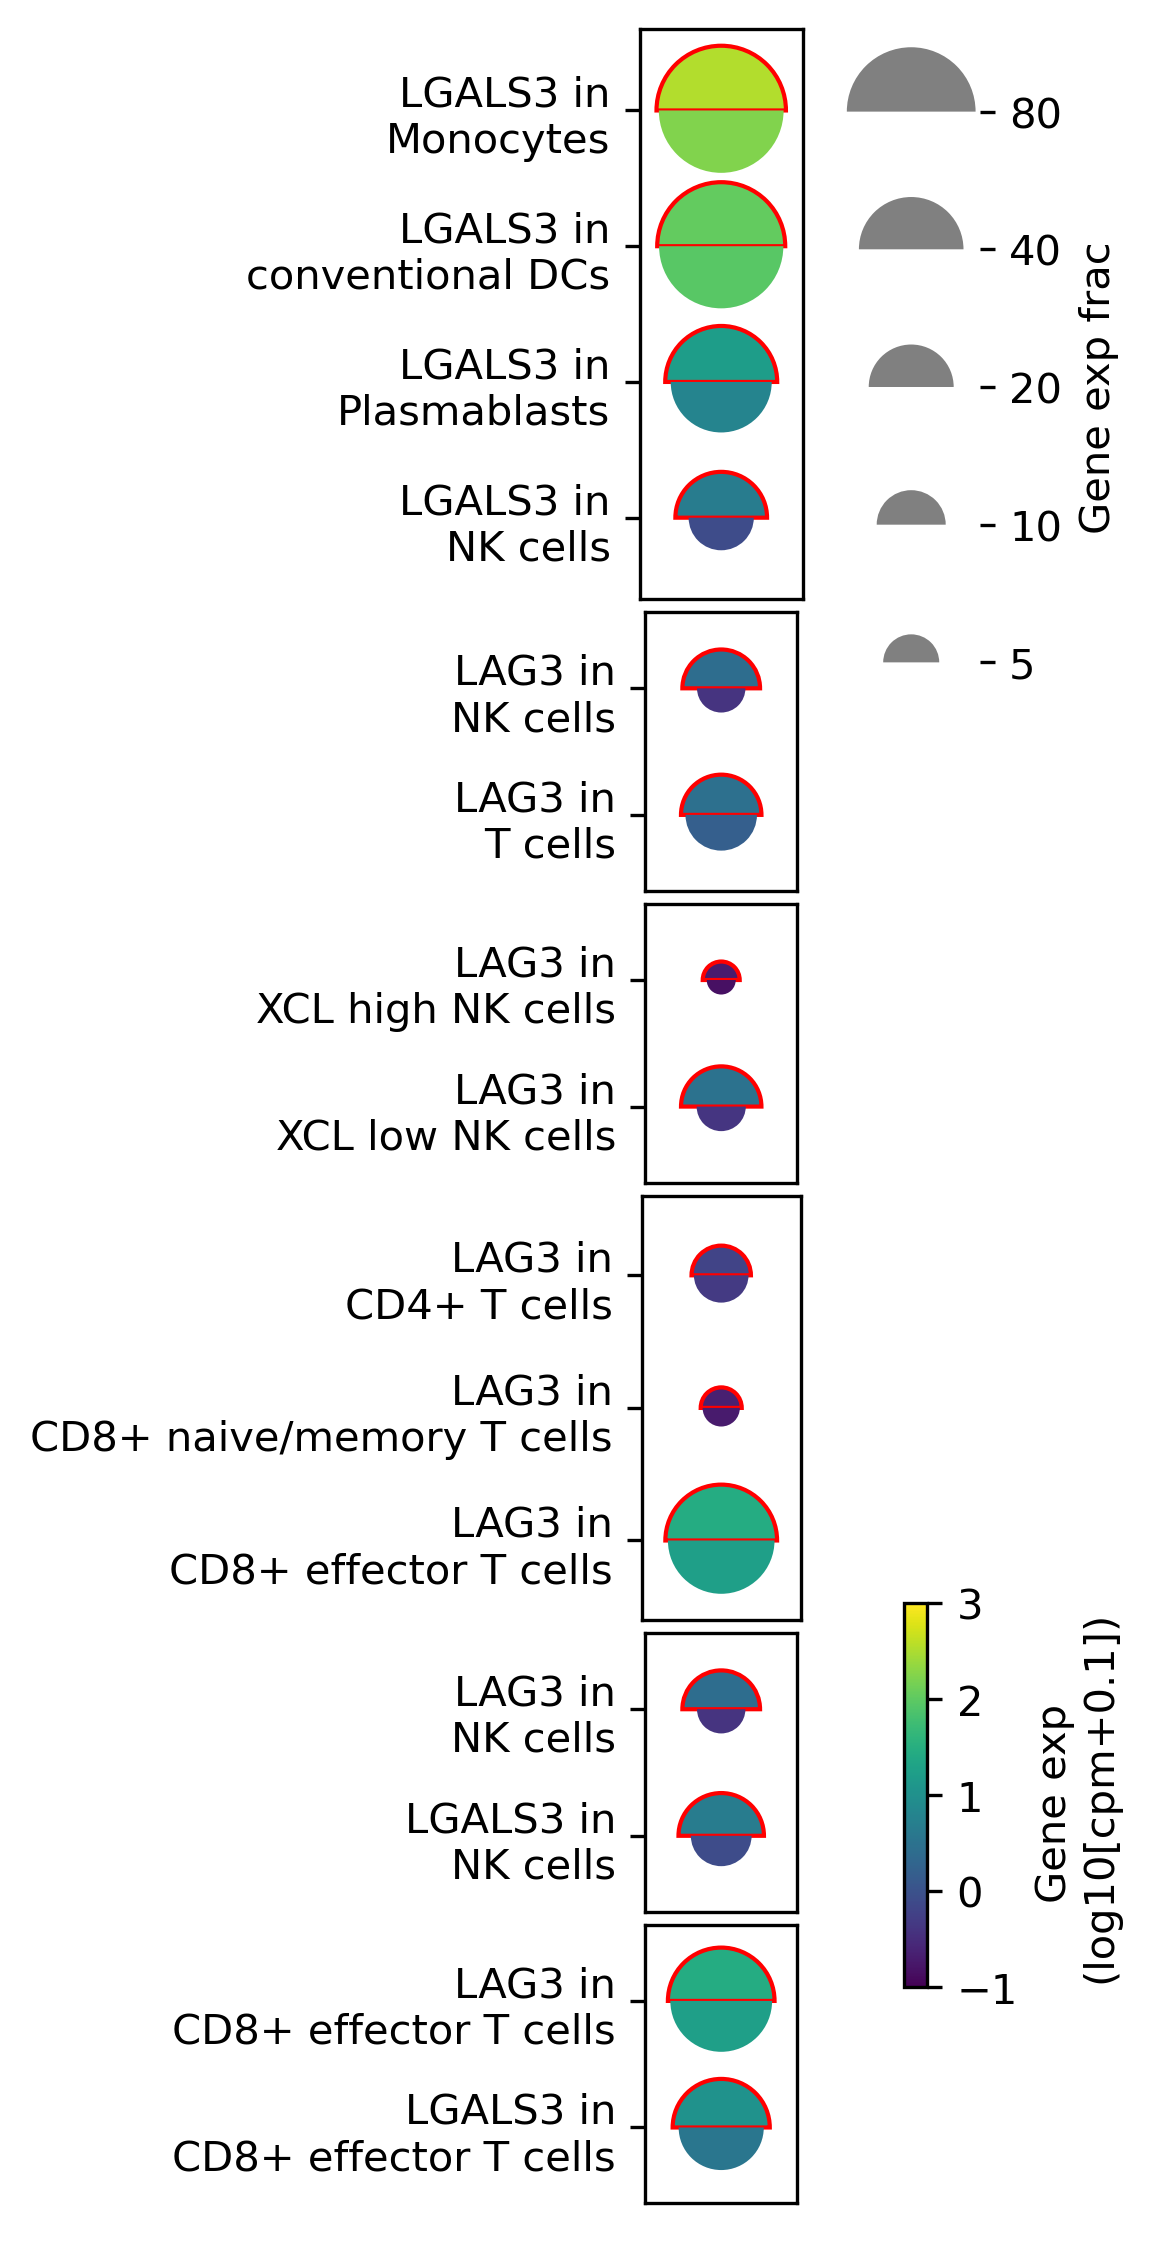

In [153]:
genes3 = [{'LGALS3': [#'B_cells',
                 #'T_cells',
                 'NK_cells',
                 'Plasmablasts',
                 #'plasmacytoid DCs',
                 'conventional DCs',
                 'Monocytes',
                 #'megakaryocytes',
        ]},
          {'LAG3': [#'B_cells',
                 'T_cells',
                 'NK_cells',
                 #'Monocytes',
                 #'Plasmablasts',
                 #'plasmacytoid DCs',
                 #'conventional DCs',
                 #'megakaryocytes'
          ],},
        
         {'LAG3': ['XCL_low NK cells', 'XCL_high NK cells',],}, 
         {'LAG3': [  'CD8+ effector T cells', 'CD8+ naive/memory T cells', 'CD4+ T cells',],},
          
         {'LGALS3': ['NK_cells'], 'LAG3': ['NK_cells'],},
         {'LGALS3': ['CD8+ effector T cells'], 'LAG3': ['CD8+ effector T cells'],},
         ]
s_mushrooms(genes3)['figure'].savefig('/home/yike/phd/dengue/figures/paper_figure/dataset_20211001/LGALS3-LAG3/' + 'LGALS3-LAG3_in_cts.png', bbox_inches='tight')


# plots for supporting LGALS3-LAG3 interaction

In [523]:
test_genes = {
    'XCL_low NK cells': ['LAG3'],
    'CD8+ effector T cells': ['LAG3']
}
res = randomization_gene(adata_kid, test_genes)
res.to_csv(save_tabels + 'final/LAG3_in_XCL_low_CD8.tsv', sep='\t')

/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900


In [526]:
def randomization_gene_plot(fdn, ran_genes, ran_res):
    for inter in ran_genes:
        fig, ax = plt.subplots(figsize=[3, 3], dpi=300)
        ct = inter['cell_type']
        gene = inter['gene']

        log2fc = ran_res.loc[ct, gene]

        x0 = log2fc['log2fc_ct'].tolist()[0]
        y0 = log2fc['log2fc_unct'].tolist()[0]    

        x = log2fc['log2fc_ct'].tolist()[1:]
        y = log2fc['log2fc_unct'].tolist()[1:]

        ax.scatter(x0, y0, c='r', s=10, label='original data')
        ax.scatter(x, y, c='gray', s=10, label='randomized data', alpha=0.5)
        ax.legend(loc='lower left')
        
        ax.axvline(0, c='gray', zorder=-3, lw=0.5)
        ax.axhline(0, c='gray', zorder=-3, lw=0.5)
        ax.set_ylim(-4.5, 4.5)
        ax.set_xlim(-4.5, 4.5)
        ax.set_xlabel('Log2fc of ' + gene + ' in ' + ct.replace('_', ' '))
        ax.set_ylabel('Log2fc of ' + gene + ' in ' + 'bystanders')
        p = ran_res.loc[ct, gene]['pvalue'][0]
        if p == 0:
            ax.set_title('p value < 0.001')
        else:
            ax.set_title('p value: ' + str(p))
        plt.savefig(fdn + gene + '_in_' + ct.replace('/', '_') + '.png', bbox_inches = 'tight')

<ipython-input-526-4486872c9caa>:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  log2fc = ran_res.loc[ct, gene]
<ipython-input-526-4486872c9caa>:25: PerformanceWarning: indexing past lexsort depth may impact performance.
  p = ran_res.loc[ct, gene]['pvalue'][0]


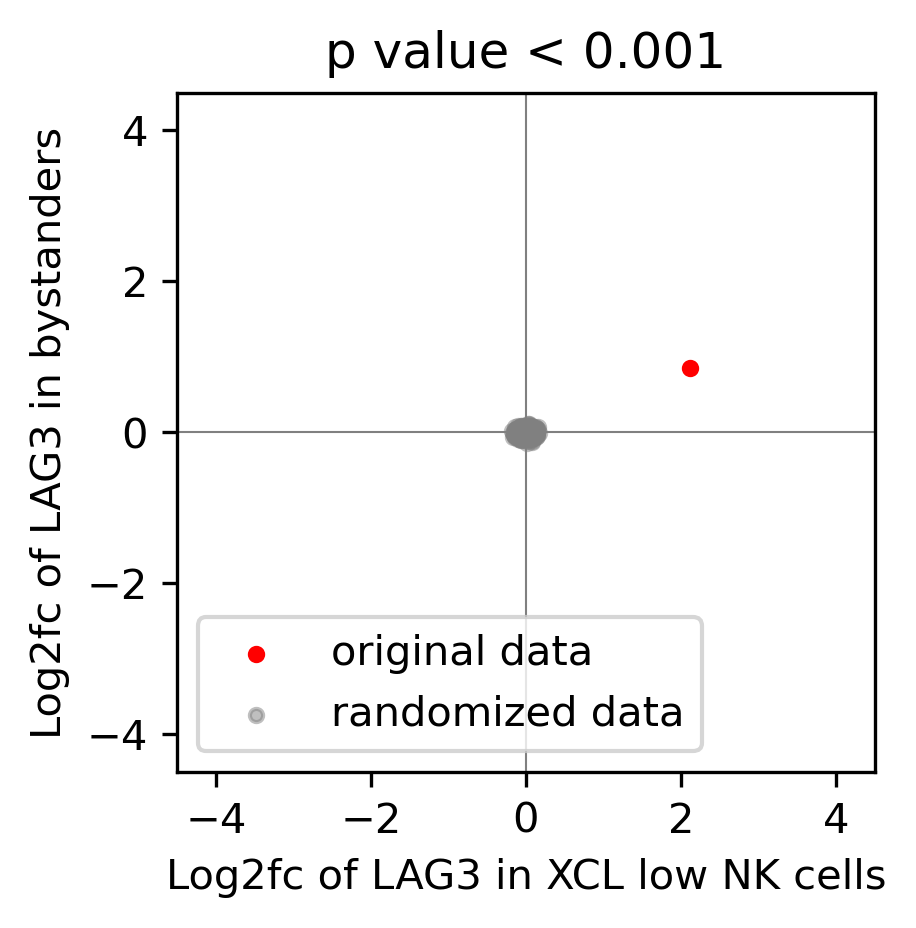

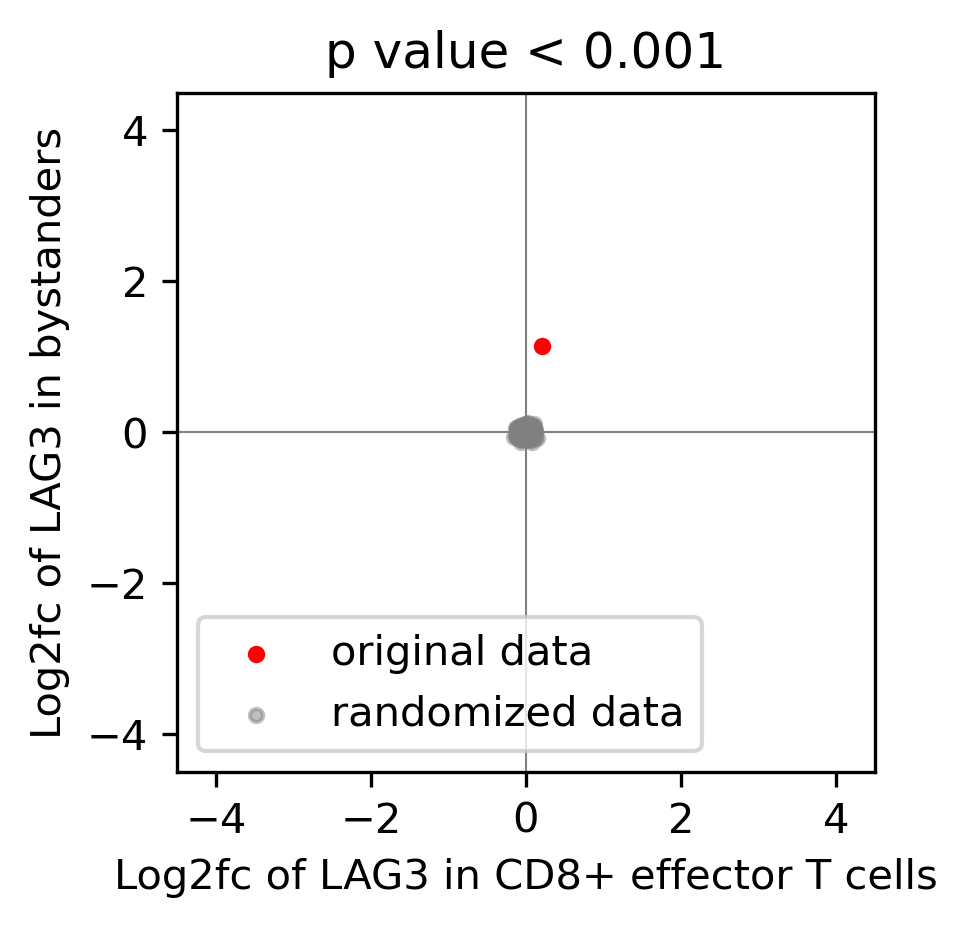

In [527]:
ran_genes = [{'cell_type': 'XCL_low NK cells', 'gene': 'LAG3'}, 
             {'cell_type': 'CD8+ effector T cells', 'gene': 'LAG3'}]
randomization_gene_plot(save_figures, ran_genes,  res)

{'figure': <Figure size 1050x900 with 2 Axes>, 'ax': <AxesSubplot:>}

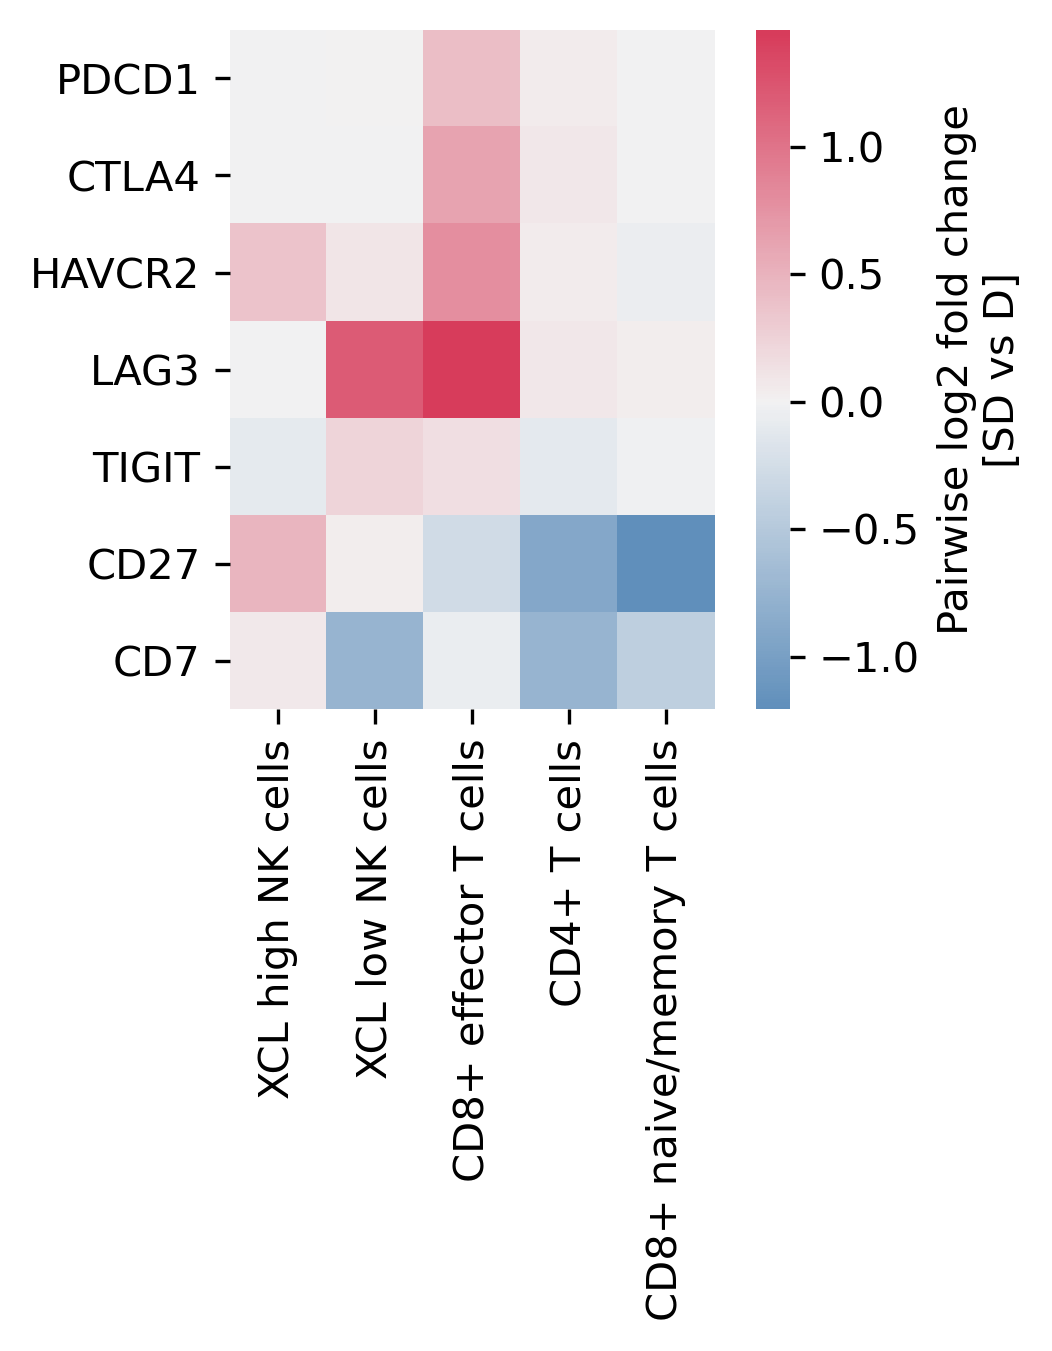

In [531]:
def heatmap_cst_h(g_list, cst_order, title, vs_type='SD vs D', save_fd=False):
    
    df = cst_pair.reset_index().set_index('gene').loc[g_list][['cell_subtype', 'med_pair']]
    df_new = pd.DataFrame(np.zeros([len(df.index.unique()), len(cst_order)]), columns=cst_order, index=g_list)

    for idx in df_new.index:    
        for col in df_new.columns:
            df_new.at[idx, col] = df.loc[idx][df.loc[idx]['cell_subtype'] == col]['med_pair'][0]

    fig, ax = plt.subplots(figsize=[0.5 * len(g_list), 0.5 + 0.5 * len(cst_order)], dpi=300)
    cmap = sns.diverging_palette(245, 5, as_cmap=True)
    ax = sns.heatmap(df_new, cmap=cmap, center=0, yticklabels=True, square=True,
                     cbar_kws={'label': 'Pairwise log2 fold change\n[%s]'%vs_type})
    ax.set_title(title, x=0.5, y=1.05)
    ax.set_ylabel(None)
    xlabels = [label.get_text().replace('_', ' ') for label in ax.get_xticklabels()]
    ax.set_xticklabels(xlabels)

    if save_fd is not False:
        fig.savefig(save_figures + save_fd, bbox_inches='tight')

    return {'figure': fig, 'ax': ax}

mark_list = ['PDCD1', 'CTLA4', 'HAVCR2', 'LAG3', 'TIGIT', 'CD27', 'CD7']
heatmap_cst_h(mark_list, 
              ['XCL_high NK cells', 
               'XCL_low NK cells', 
               'CD8+ effector T cells', 
               'CD4+ T cells', 
               'CD8+ naive/memory T cells',
               ], 
             title=None, 
             save_fd='heatmap_killing_markers.png')

In [538]:
cst_inters

ga_med_pair  \
ga    csta                  gb    cstb                                 
FYN   CD8+ effector T cells PTPRC naive B cells             1.347017   
                                  XCL_low NK cells          1.347017   
                                  CD4+ T cells              1.347017   
                                  XCL_high NK cells         1.347017   
                                  CD8+ effector T cells     1.347017   
...                                                              ...   
ITGAX conventional DCs      FCER2 naive B cells             1.374880   
ITGB2 XCL_high NK cells     FCER2 naive B cells             1.663869   
      conventional DCs      FCER2 naive B cells             1.888788   
      activated B cells     FCER2 naive B cells             1.626236   
ITGAM macrophages           FCER2 naive B cells             1.512713   

                                                         ga_fra_pair  \
ga    csta                  gb    cstb                                 
FYN   CD8+ effector T cells PTPRC naive B cells             0.734375   
                                  XCL_low NK cells          0.734375   
                                  CD4+ T cells              0.734375   
                                  XCL_high NK cells         0.734375   
                                  CD8+ effector T cells     0.734375   
...                                                              ...   
ITGAX conventional DCs      FCER2 naive B cells             0.805556   
ITGB2 XCL_high NK cells     FCER2 naive B cells             0.767857   
      conventional DCs      FCER2 naive B cells             0.888889   
      activated B cells     FCER2 naive B cells             0.928571   
ITGAM macrophages           FCER2 naive B cells             0.857143   

                                                         ga_neg_fra_pair  \
ga    csta                  gb    cstb                                     
FYN   CD8+ effector T cells PTPRC naive B cells                 0.265625   
                                  XCL_low NK cells              0.265625   
                                  CD4+ T cells                  0.265625   
                                  XCL_high NK cells             0.265625   
                                  CD8+ effector T cells         0.265625   
...                                                                  ...   
ITGAX conventional DCs      FCER2 naive B cells                 0.535714   
ITGB2 XCL_high NK cells     FCER2 naive B cells                 0.303571   
      conventional DCs      FCER2 naive B cells                 0.303571   
      activated B cells     FCER2 naive B cells                 0.303571   
ITGAM macrophages           FCER2 naive B cells                 0.410714   

                                                         ga_SD_fra  ga_D_fra  \
ga    csta                  gb    cstb                                         
FYN   CD8+ effector T cells PTPRC naive B cells           0.485191  0.432716   
                                  XCL_low NK cells        0.485191  0.432716   
                                  CD4+ T cells            0.485191  0.432716   
                                  XCL_high NK cells       0.485191  0.432716   
                                  CD8+ effector T cells   0.485191  0.432716   
...                                                            ...       ...   
ITGAX conventional DCs      FCER2 naive B cells           0.413636  0.248366   
ITGB2 XCL_high NK cells     FCER2 naive B cells           0.822695  0.670980   
      conventional DCs      FCER2 naive B cells           0.959091  0.843137   
      activated B cells     FCER2 naive B cells           0.304010  0.217027   
ITGAM macrophages           FCER2 naive B cells           0.331250  0.103030   

                                                         gb_med_pair  \
ga    csta                  gb    cstb                                 
FYN   CD8

In [545]:
cst_pair.loc['XCL_low NK cells', 'HLA-DRA']

med_pair            6.749229e-01
fra_pair            8.035714e-01
neg_fra_pair        1.964286e-01
S_fra               1.696711e-01
NS_fra              7.463702e-02
S_avg               1.892621e+00
NS_avg              6.056870e-01
log2_fold_change    8.491864e-01
statistic           9.503407e-02
pvalue              2.152665e-29
Name: (XCL_low NK cells, HLA-DRA), dtype: float64

In [551]:
sns.color_palette('colorblind', 8)
# 'set 1'

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451)]

In [552]:
# for ct, c in zip(cts, sns.color_palette('colorblind', 8)):
    

['B_cells',
 'NK_cells',
 'T_cells',
 'Monocytes',
 'Plasmablasts',
 'plasmacytoid DCs',
 'conventional DCs',
 'megakaryocytes']